# MusicXML tokenizer

In [1]:
import music21
from fractions import Fraction

from music21 import environment
env = environment.UserSettings()
env['musicxmlPath'] = '/home/frederic/MuseScore-Studio-4.3.2.241630832-x86_64.AppImage'
env['musescoreDirectPNGPath'] = '/home/frederic/MuseScore-Studio-4.3.2.241630832-x86_64.AppImage'

### Tokenizer

Here is the main tokenizer function. The needed features of the score are tokenized. Aside from that, I also tokenized voices inside parts, dynamics and tempo (metronome marks). For that purpose, I worked on the music21 parsed elements. The tokenization is done part-wise, but when voices appear, inside a part, the voices are tokenized bar wise (i.e., part token first, then bar token, then all notes in a voice with the voice token first, then the next voice, and then next bar).

In [ ]:
from pathlib import Path


def tokenize(score):
    """This function takes a music21 score object as input and returns a list of tokens representing the musical information in the score."""
    if isinstance(score, str) or isinstance(score, Path):
        score = music21.converter.parse(score)

    tokens = ["<BOS>"]
    for element in score.recurse():
        if isinstance(element, music21.stream.Part):
            tokens.append(f"PART_{element.id}")
        
        elif isinstance(element, music21.clef.Clef):
            tokens.append(f"CLEF_{element.sign}_{element.line}")
        
        elif isinstance(element, music21.meter.TimeSignature):
            tokens.append(f"TIME_SIG_{element.numerator}/{element.denominator}")
        
        elif isinstance(element, music21.key.KeySignature):
            if isinstance(element, music21.key.Key):
                tokens.append(f"KEY_{element.tonic.name}_{element.mode}")
            else:
                '''
                I have encountered some key signatures that are not purely written,
                because actually the KeySignature object sometimes only contains the number of sharps/flats, and not the tonic/mode.
                Therefore, in this case, I just decided to convert it to the relative major key.
                The actual token then can sometimes be wrong, but at least in the detokenized version later on it will contain also
                the correct number of sharps/flats.
                '''
                key_obj = element.asKey(mode='major')
                tokens.append(f"KEY_{key_obj.tonic.name}_{key_obj.mode}")
        
        elif isinstance(element, music21.stream.Measure):
            tokens.append(f"BAR_{element.number}")
        
        elif isinstance(element, music21.note.Note):
            tokens.append(f"POS_BAR_{element.offset}")
            tokens.append(f"POS_ABS_{element.getOffsetInHierarchy(score)}")
            tokens.append(f"PITCH_{element.pitch.nameWithOctave}")
            tokens.append(f"DUR_{element.duration.quarterLength}")
        
        elif isinstance(element, music21.chord.Chord):
            pitches = element.pitches
            for pitch in pitches:
                tokens.append(f"POS_BAR_{element.offset}")
                tokens.append(f"POS_ABS_{element.getOffsetInHierarchy(score)}")
                tokens.append(f"PITCH_{pitch.nameWithOctave}")
                tokens.append(f"DUR_{element.duration.quarterLength}")
        
        elif isinstance(element, music21.note.Rest):
            tokens.append(f"REST_{element.duration.quarterLength}")
        
        elif isinstance(element, music21.stream.Voice):
            '''
             I have seen that some measures contain multiple voices, which are represented as separate Voice objects in music21.
             In order to be able to treat everything as a single stream, I decided to just add a token for each voice, so that
             no information from the score is lost (some score for choir (SATB) are sometimes in only 2 staffs, 2 parts, with 2 voices each).
             I tried other solutions to merge voices in a part into a single voice part, with the chordify method for example. However,
             chordify lost the real timing of objects (if Soprano and Alto have 2 quarter notes and a half note starting at the same time
             as the first time of the first quarter note, chordify converts that into two quarters, losing the information that Alto note is actually a half note).
             Another technique I tried was to merge manually, per bar, which worked quite well. 
             However, in the end, in order to not lose information, I though it was a better idea
             to just keep the voices information in the tokenization, and detoknize accordingly later on.
            '''
            tokens.append(f"VOICE_{element.id}")
        
        elif isinstance(element, music21.tempo.MetronomeMark):
            # I have added metronome marks information in the tokenizer too, only metronome marks with numbers though
            # Adagio, Presto, etc are usually encoded as TextExpression nevertheless, but I encountered some MetronomeMarks with None as number
            if element.number is not None:
                ref = element.referent.quarterLength if element.referent is not None else 1.0
                tokens.append(f"TEMPO_{element.number}_{ref}")

        elif isinstance(element, music21.dynamics.Dynamic):
            # I have added dynamics information in the tokenizer too
            tokens.append(f"DYNAMIC_{element.value}")

    tokens.append("<EOS>")
    return tokens

This is an example of a tokens generated in one of the samples i worked on in order to get everything I wanted. I looked at the main music21 events that were collected, and the tokenizer was built with depending on the expressions I got. However, for dynamics, in this particular example, apparently the dynamics do not appear to be collected as dynamic objects, but I guess they appear as TextExpression, like 'Adagio' is. \ue520 and \ue522 tend to appear quite regularly and seem to match the positions of the forte and piano in the score. I did not deal with that way of encoding Dynamics particularly, but I only with Dynamics music21 objects, which appeared in some of the examples, as you might see later.

In [29]:
example = "examples/Qmb26rWhtURDr6GU4rRWqtNxLzGa9BWjXug5YvU2MF1f8R.mxl"
score = music21.converter.parse(example)
tokens = tokenize(score)
print(tokens)
for element in score.recurse():
    print(element)

['<BOS>', 'PART_Classical Guitar', 'BAR_1', 'CLEF_G_2', 'TEMPO_40_1.5', 'KEY_C_major', 'TIME_SIG_6/8', 'VOICE_1', 'POS_BAR_0.0', 'POS_ABS_0.0', 'PITCH_A3', 'DUR_1.0', 'POS_BAR_0.0', 'POS_ABS_0.0', 'PITCH_C4', 'DUR_1.0', 'POS_BAR_1.0', 'POS_ABS_1.0', 'PITCH_A3', 'DUR_0.5', 'POS_BAR_1.0', 'POS_ABS_1.0', 'PITCH_C4', 'DUR_0.5', 'POS_BAR_1.5', 'POS_ABS_1.5', 'PITCH_A3', 'DUR_0.75', 'POS_BAR_1.5', 'POS_ABS_1.5', 'PITCH_C4', 'DUR_0.75', 'POS_BAR_2.25', 'POS_ABS_2.25', 'PITCH_D4', 'DUR_0.25', 'POS_BAR_2.5', 'POS_ABS_2.5', 'PITCH_C4', 'DUR_0.5', 'VOICE_4', 'POS_BAR_0.0', 'POS_ABS_0.0', 'PITCH_A2', 'DUR_1.0', 'POS_BAR_1.0', 'POS_ABS_1.0', 'PITCH_A2', 'DUR_0.5', 'POS_BAR_1.5', 'POS_ABS_1.5', 'PITCH_A2', 'DUR_1.5', 'BAR_2', 'VOICE_1', 'POS_BAR_0.0', 'POS_ABS_3.0', 'PITCH_G#3', 'DUR_1.0', 'POS_BAR_0.0', 'POS_ABS_3.0', 'PITCH_B3', 'DUR_1.0', 'POS_BAR_1.0', 'POS_ABS_4.0', 'PITCH_G#3', 'DUR_0.5', 'POS_BAR_1.0', 'POS_ABS_4.0', 'PITCH_B3', 'DUR_0.5', 'POS_BAR_1.5', 'POS_ABS_4.5', 'PITCH_G#3', 'DUR_1.0',

### Detokenizer

Here I implemented the detokenizer given a sequence of tokens. Actually, we build recursively the music21 score object, with the corresponding parts, measures and voices when they appear. Moreover, in order to deal with notes coming at the same time, I went with the approach of stacking all notes until next POS_BAR token or a new BAR, PROGRAM, VOICE, REST, CLEF, TIME_SIGNATURE, TEMPO or DYNAMIC token appears, so that I create a chord item of the simultaneous notes in the voice or part.

In [30]:
def detokenize(tokens):
    score = music21.stream.Score()
    current_part = None
    current_measure = None
    current_voice = None   
    current_note = None
    current_pos_bar = None  # track current bar offset
    pending_notes = []      # buffer notes at same offset
    pending_pos = None      # offset those notes belong to

    def active_target():
        """Return the most specific active container for notes."""
        if current_voice is not None:
            return current_voice
        if current_measure is not None:
            return current_measure
        return current_part

    def flush_pending(target):
        """Flush buffered notes as a Note or Chord into target."""
        nonlocal pending_notes, pending_pos
        if not pending_notes:
            return
        if len(pending_notes) == 1:
            target.insert(pending_pos, pending_notes[0])
        else:
            chord = music21.chord.Chord(pending_notes)
            chord.duration = pending_notes[0].duration  # all share same duration
            target.insert(pending_pos, chord)
        pending_notes = []
        pending_pos = None

    for token in tokens:
        if token == "<BOS>":
            continue

        elif token.startswith("PART_"):
            flush_pending(active_target())
            part_id = token.split("_", 1)[1]
            current_part = music21.stream.Part(id=part_id)
            current_part.partName = part_id
            score.insert(0, current_part)  # ← not append
            current_measure = None
            current_voice = None
            current_note = None
            current_pos_bar = None

        elif token.startswith("TIME_SIG_") and current_part is not None:
            sig = token.split("_", 2)[2]
            numerator, denominator = sig.split("/")
            ts = music21.meter.TimeSignature(f"{numerator}/{denominator}")
            target = current_measure if current_measure is not None else current_part
            target.append(ts)

        elif token.startswith("KEY_") and current_part is not None:
            parts = token.split("_", 2)
            key = music21.key.Key(parts[1], parts[2])
            target = current_measure if current_measure is not None else current_part
            target.append(key)

        elif token.startswith("CLEF_") and current_part is not None:
            flush_pending(active_target())
            _, sign, line = token.split("_")
            clef = music21.clef.clefFromString(sign + line)
            target = current_measure if current_measure is not None else current_part
            target.append(clef)

        elif token.startswith("BAR_") and current_part is not None:
            flush_pending(active_target())
            number = int(token.split("_", 1)[1])
            current_measure = music21.stream.Measure(number=number)
            current_voice = None  # reset voice on each new bar
            current_part.append(current_measure)
            current_pos_bar = None

        elif token.startswith("VOICE_") and current_measure is not None:
            flush_pending(active_target())
            voice_id = token.split("_", 1)[1]
            current_voice = music21.stream.Voice(id=voice_id)
            current_measure.insert(0, current_voice)

        elif token.startswith("POS_BAR_"):
            new_pos = float(Fraction(token.split("_", 2)[2]))
            if pending_notes and new_pos != pending_pos:
                flush_pending(active_target())
            current_pos_bar = new_pos

        elif token.startswith("POS_ABS_"):
            continue

        elif token.startswith("PITCH_") and current_part is not None:
            pitch = token.split("_", 1)[1]
            current_note = music21.note.Note(pitch)

        elif token.startswith("DUR_") and current_part is not None:
            duration = float(Fraction(token.split("_", 1)[1]))
            if current_note is not None:
                current_note.duration.quarterLength = duration
                pending_notes.append(current_note)
                pending_pos = current_pos_bar
                current_note = None

        elif token.startswith("REST_") and current_part is not None:
            flush_pending(active_target())
            duration = float(Fraction(token.split("_", 1)[1]))
            rest = music21.note.Rest()
            rest.duration.quarterLength = duration
            active_target().insert(current_pos_bar if current_pos_bar is not None else 0, rest)
        
        elif token.startswith("TEMPO_") and current_part is not None:
            flush_pending(active_target())
            _, number, ref = token.split("_")
            bpm = float(number)
            referent = music21.duration.Duration(quarterLength=float(ref))
            tempo = music21.tempo.MetronomeMark(number=bpm, referent=referent)
            target = current_measure if current_measure is not None else current_part
            target.append(tempo)
        
        elif token.startswith("DYNAMIC_") and current_part is not None:
            flush_pending(active_target())
            dynamic_value = token.split("_", 1)[1]
            dynamic = music21.dynamics.Dynamic(dynamic_value)
            target = current_measure if current_measure is not None else current_part
            target.append(dynamic)

        elif token == "<EOS>":
            flush_pending(active_target())

    for part in score.parts:
        measures = part.getElementsByClass(music21.stream.Measure)
        if measures:
            last_measure = measures[-1]
            last_measure.rightBarline = music21.bar.Barline(type='final')

    return score

### Examples

Here is a list of examples, the original scores and the detokenized versions of them right after. These examples have been cherry-picked, with of course trying to represent different items that may appear in a score (parts, voices, dynamics, tempo changes, key changes, simultaneous notes...).


  Qmb26rWhtURDr6GU4rRWqtNxLzGa9BWjXug5YvU2MF1f8R.mxl

--- ORIGINAL ---


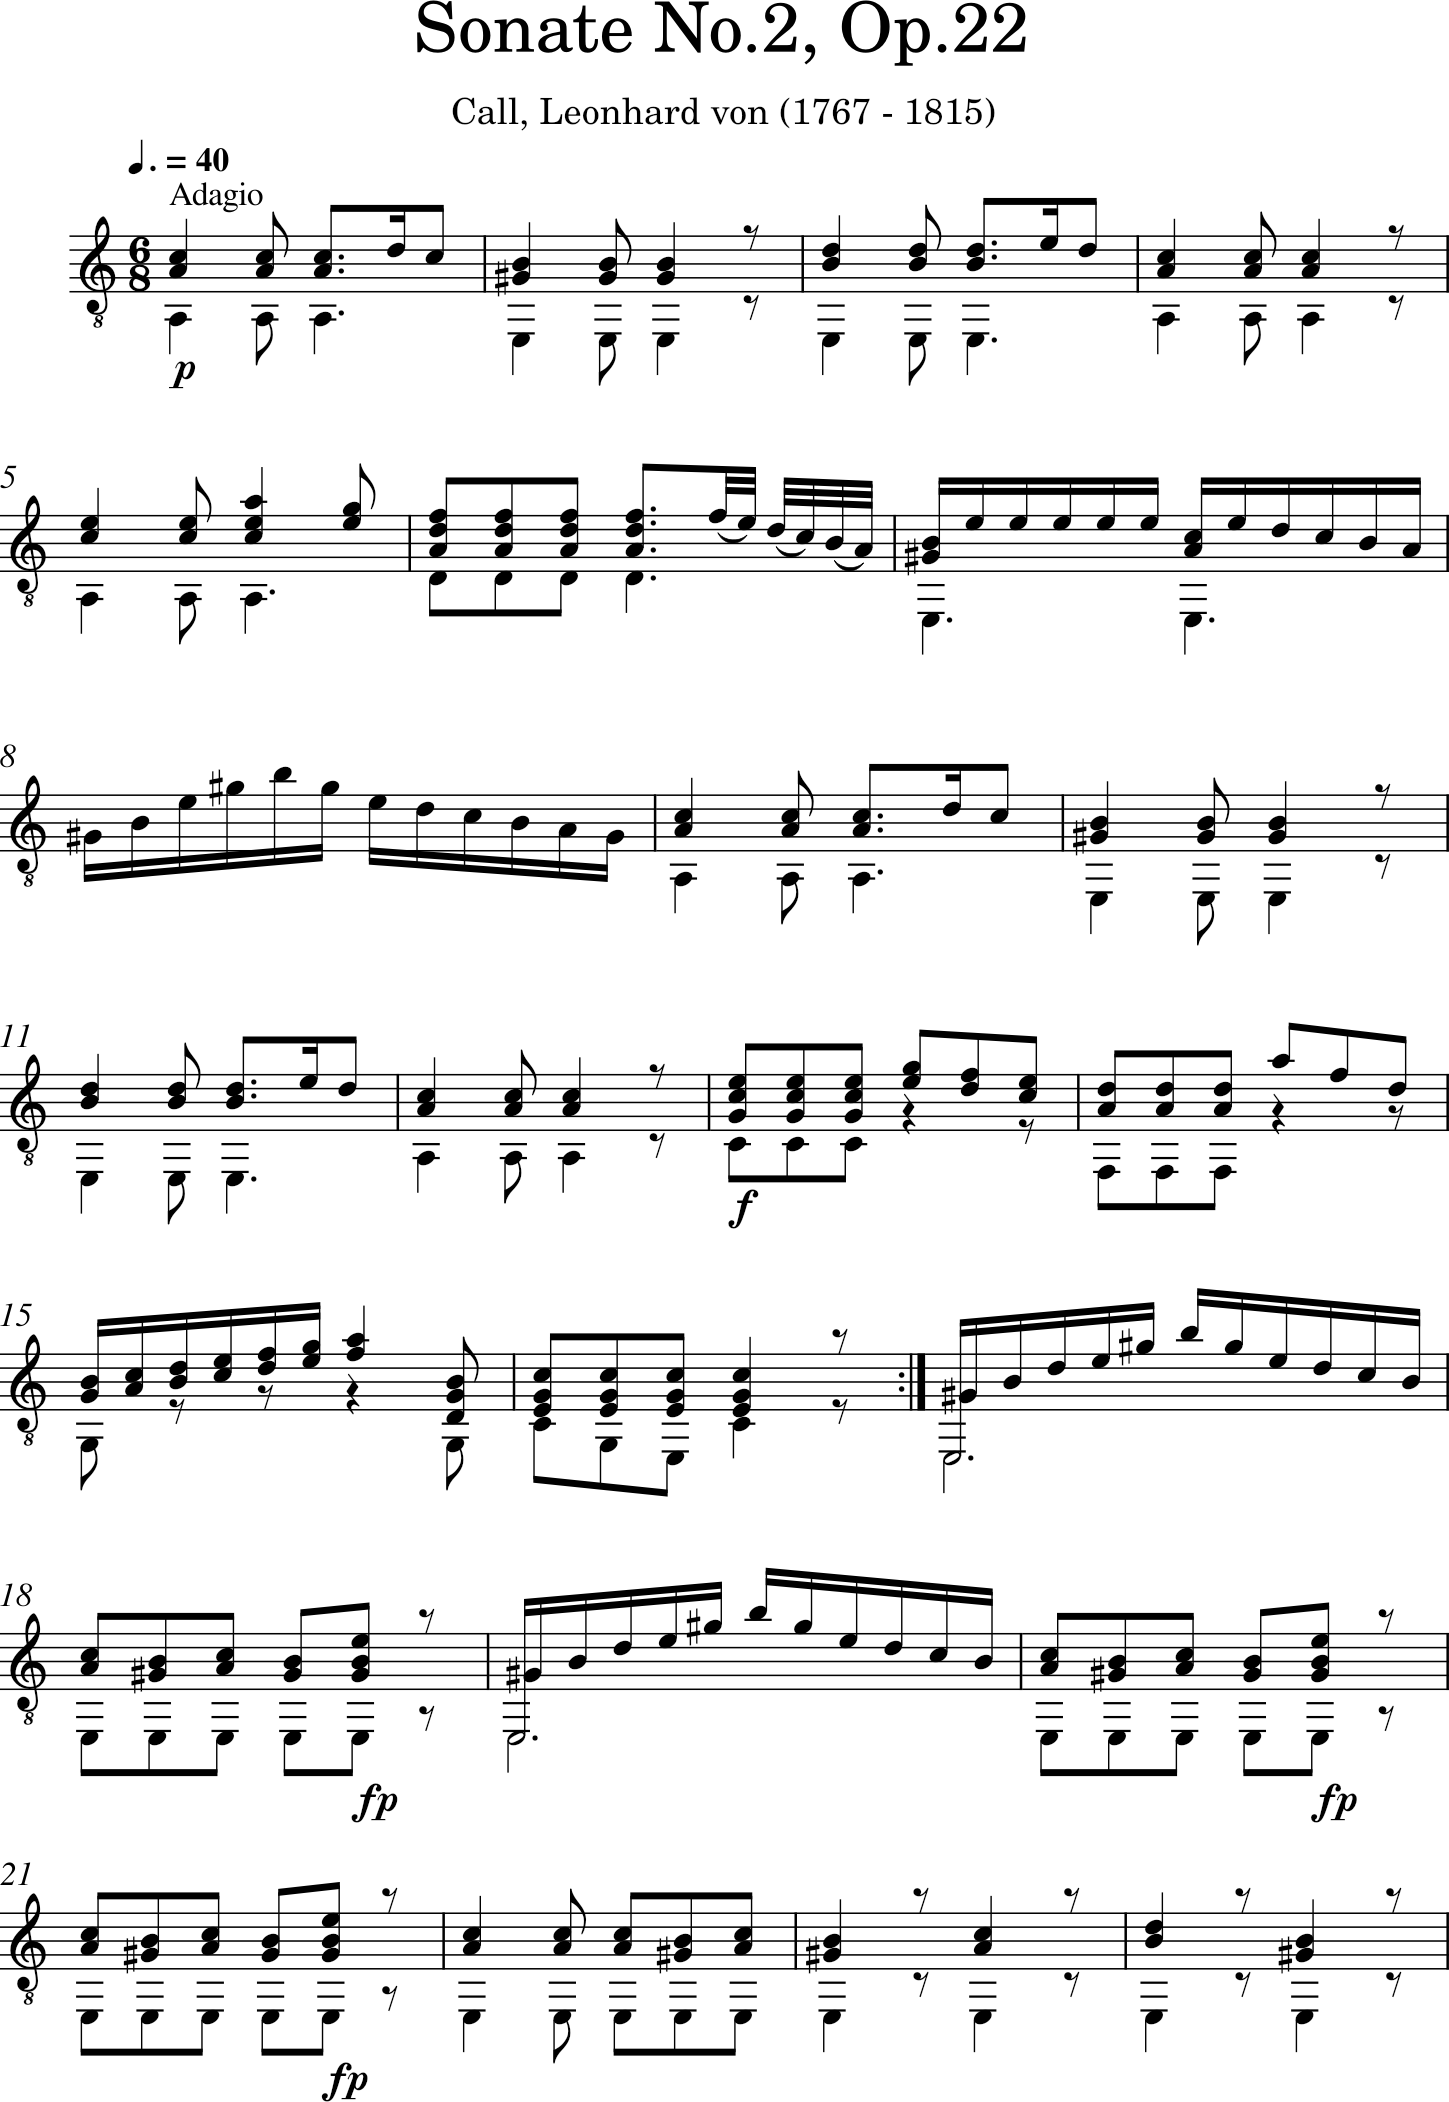

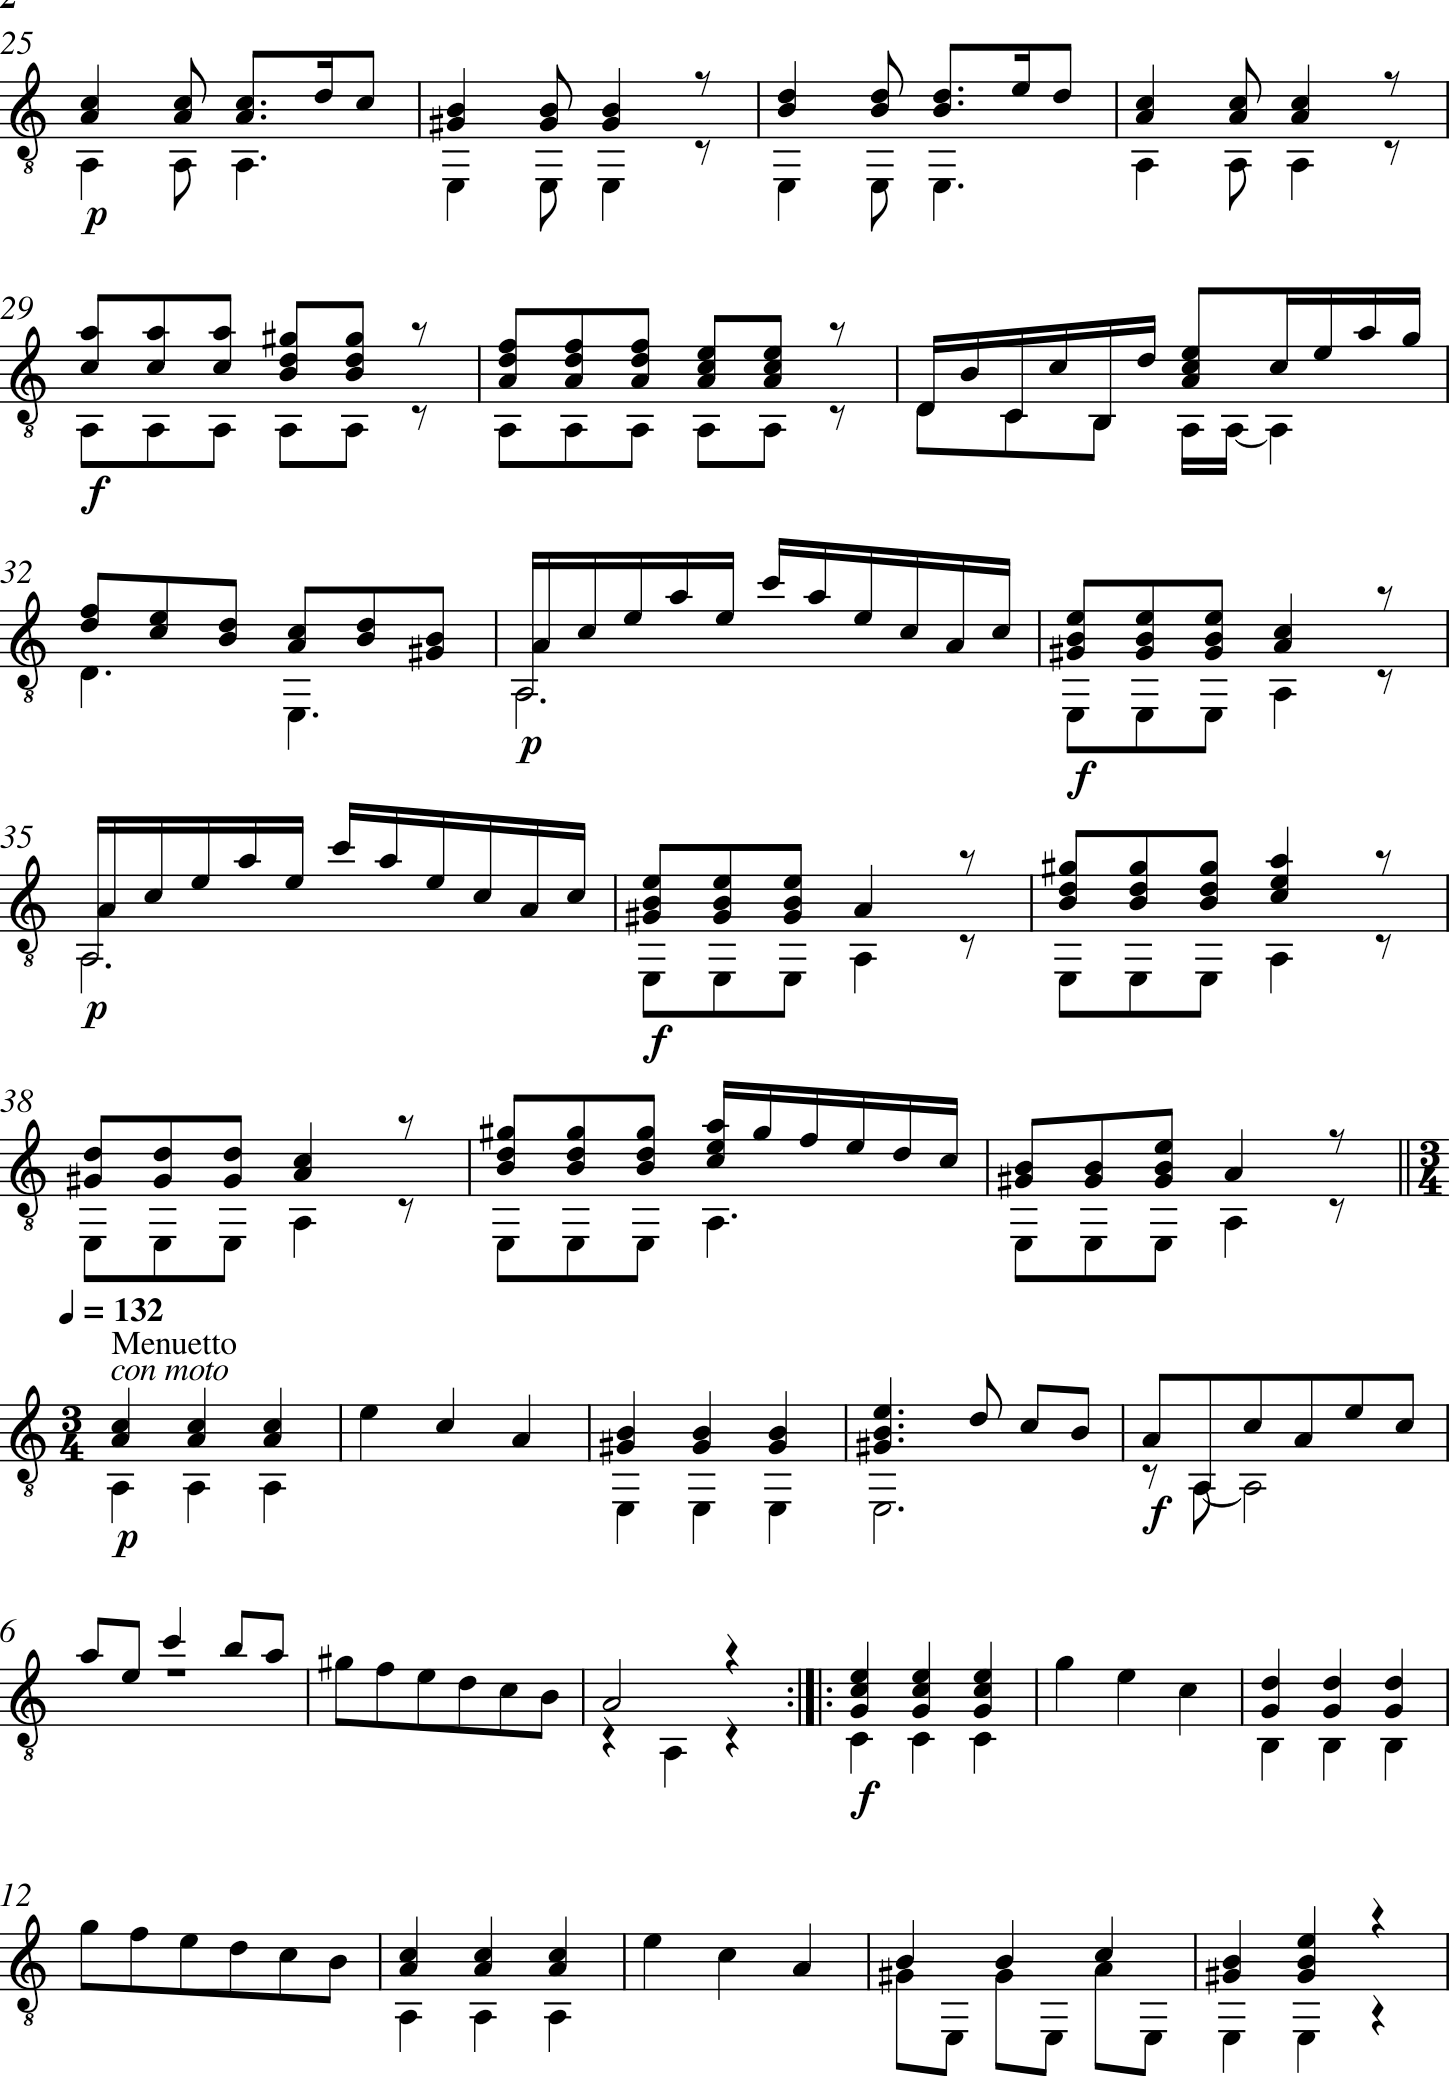

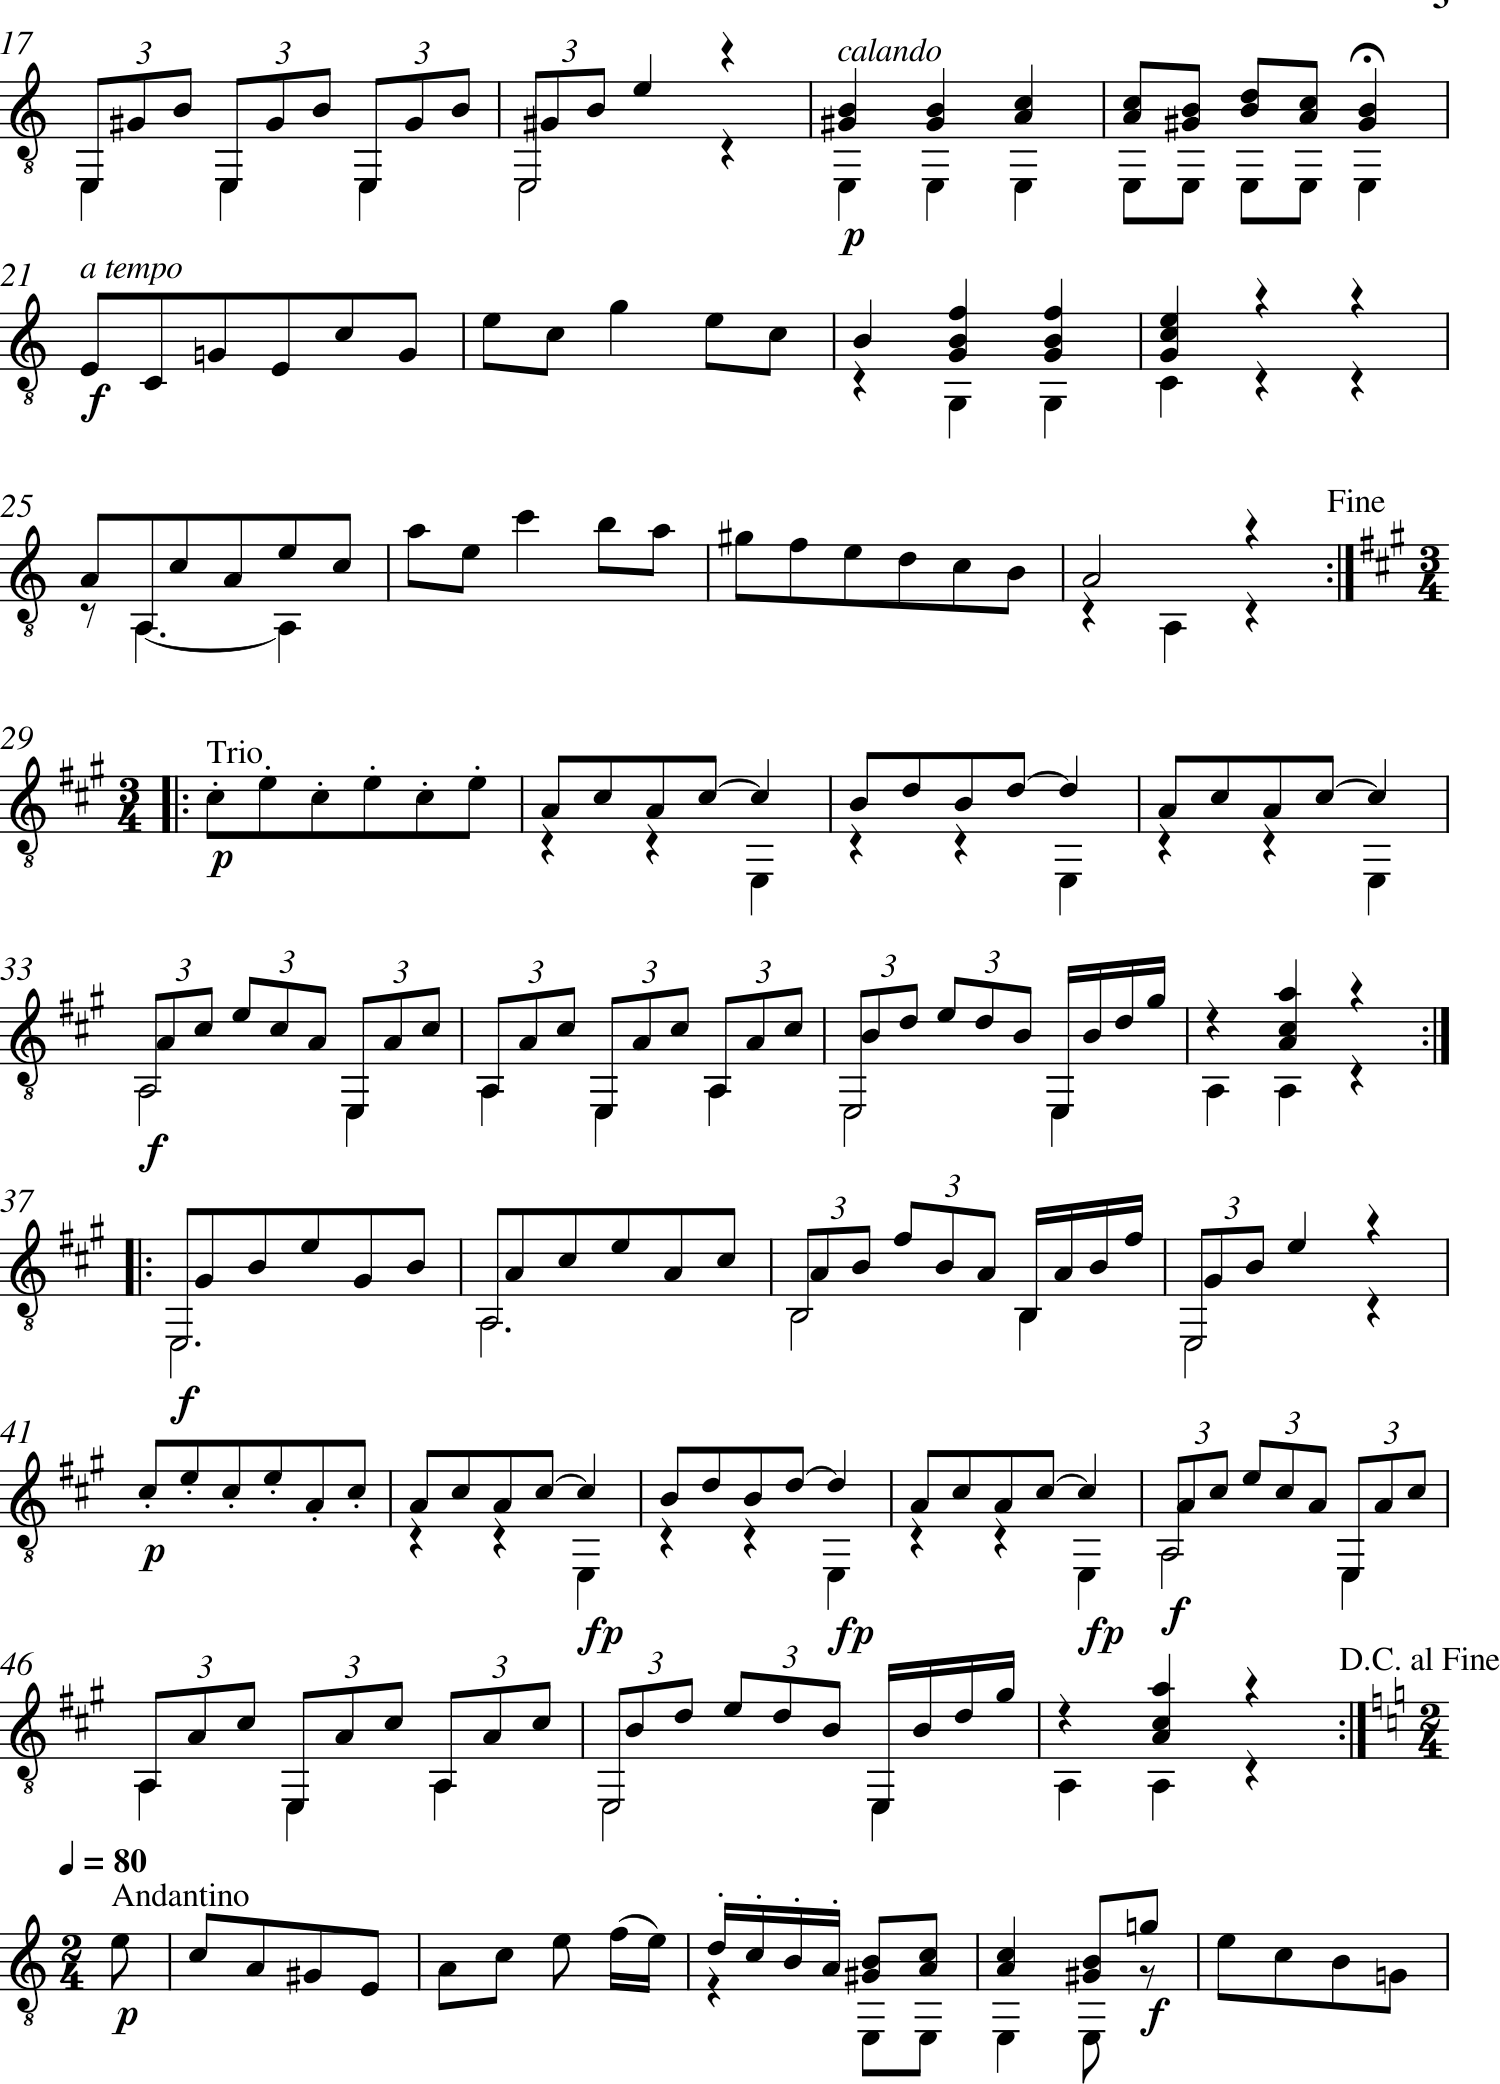

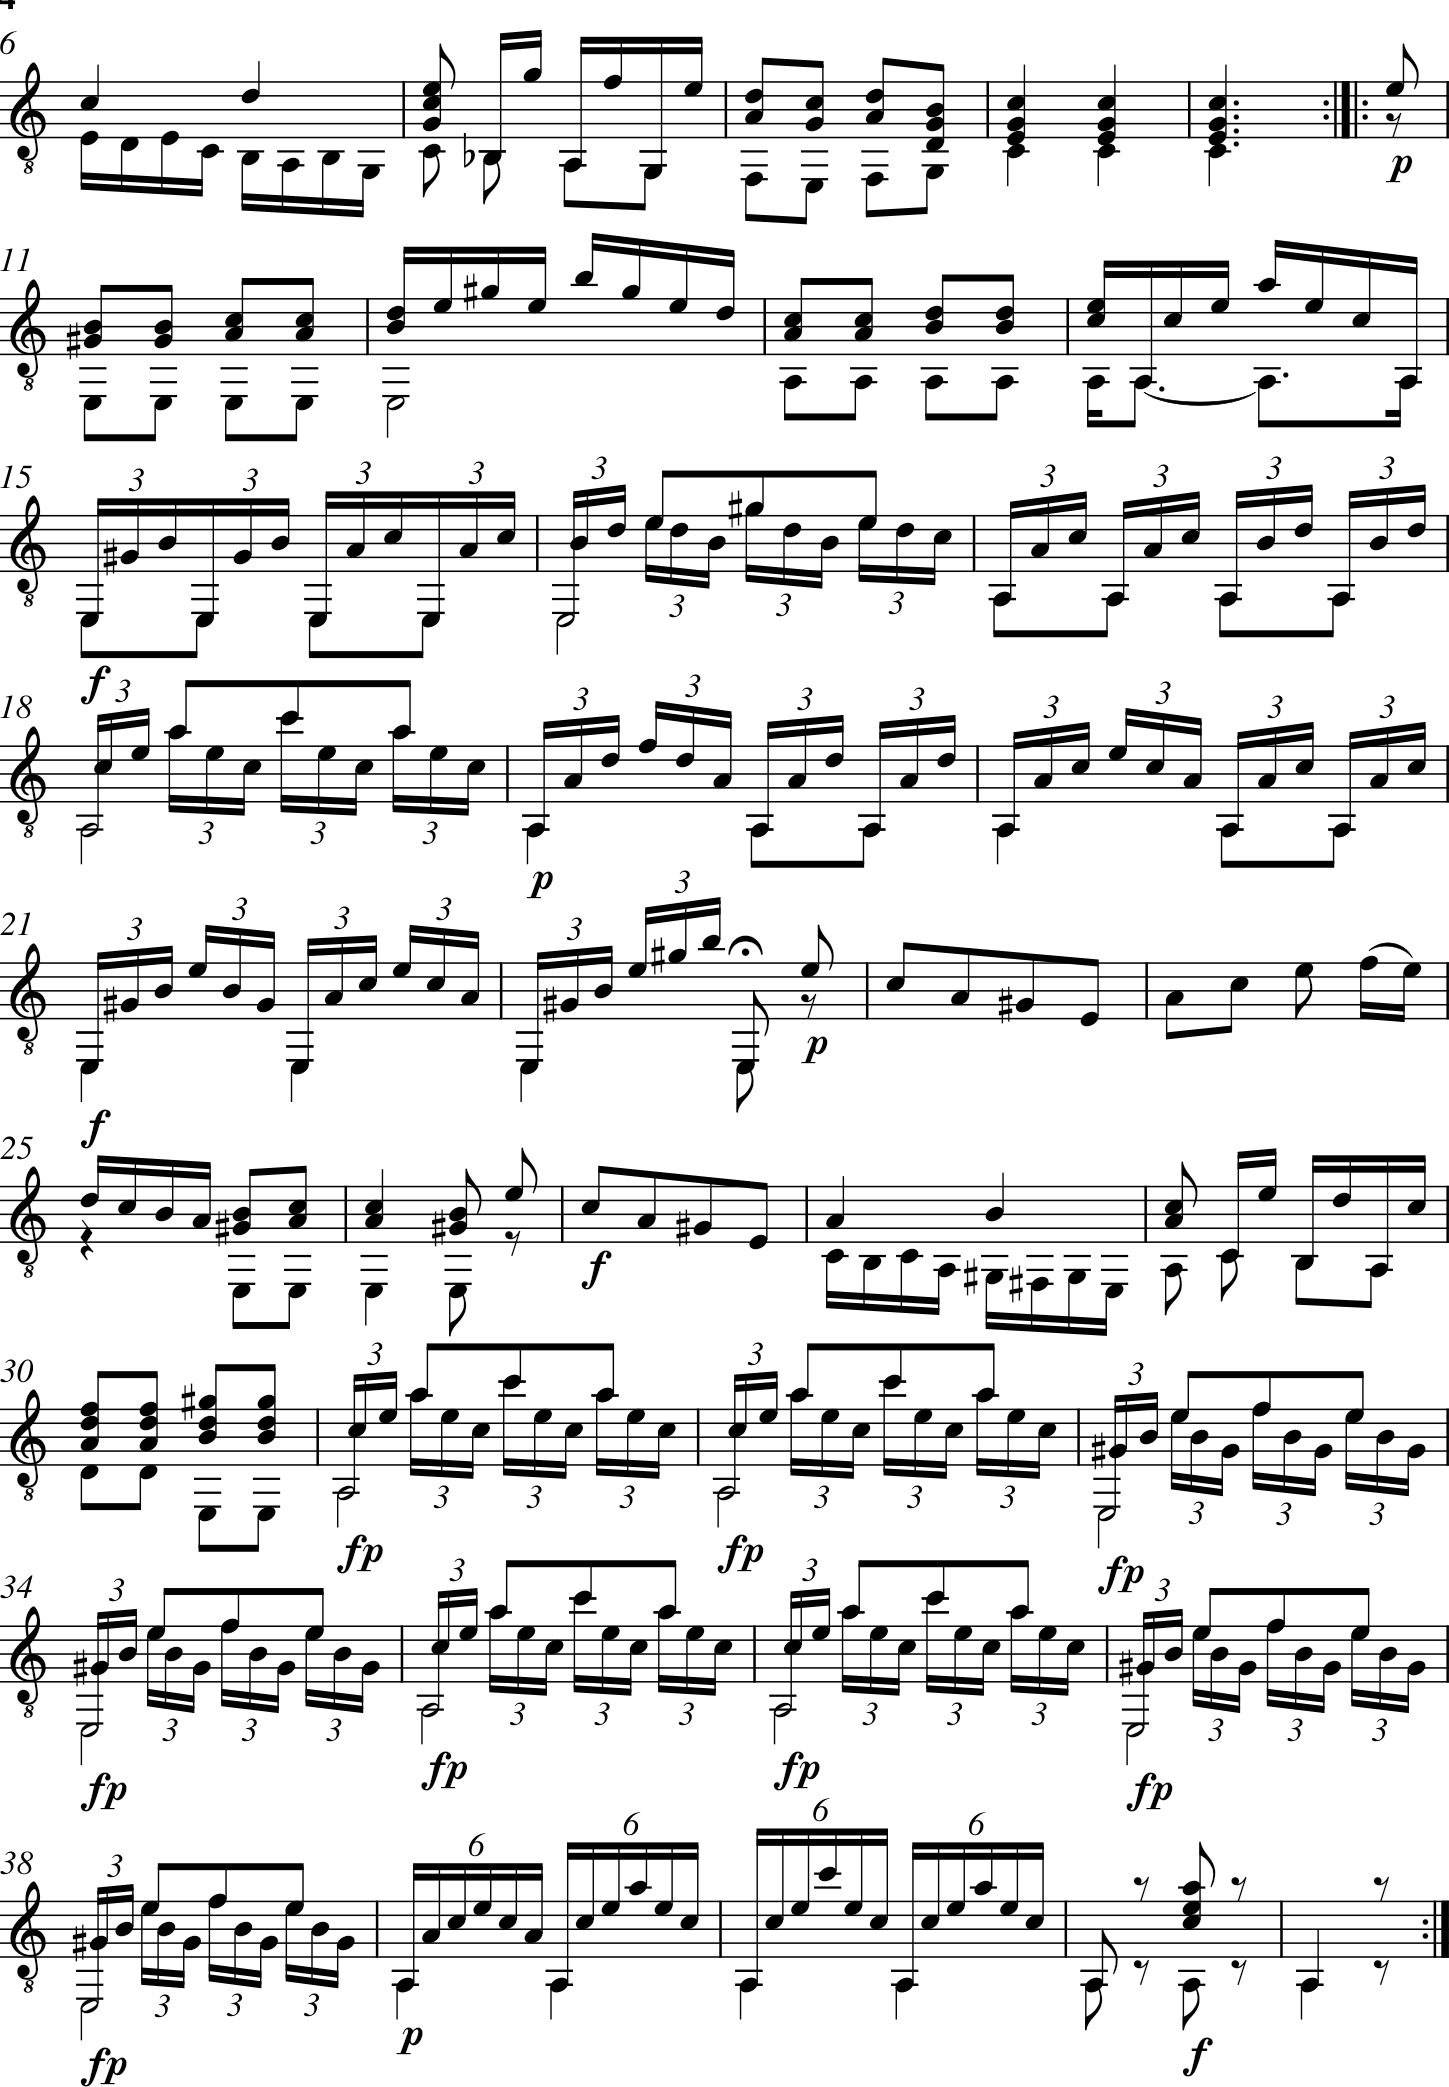


--- RECONSTRUCTED ---


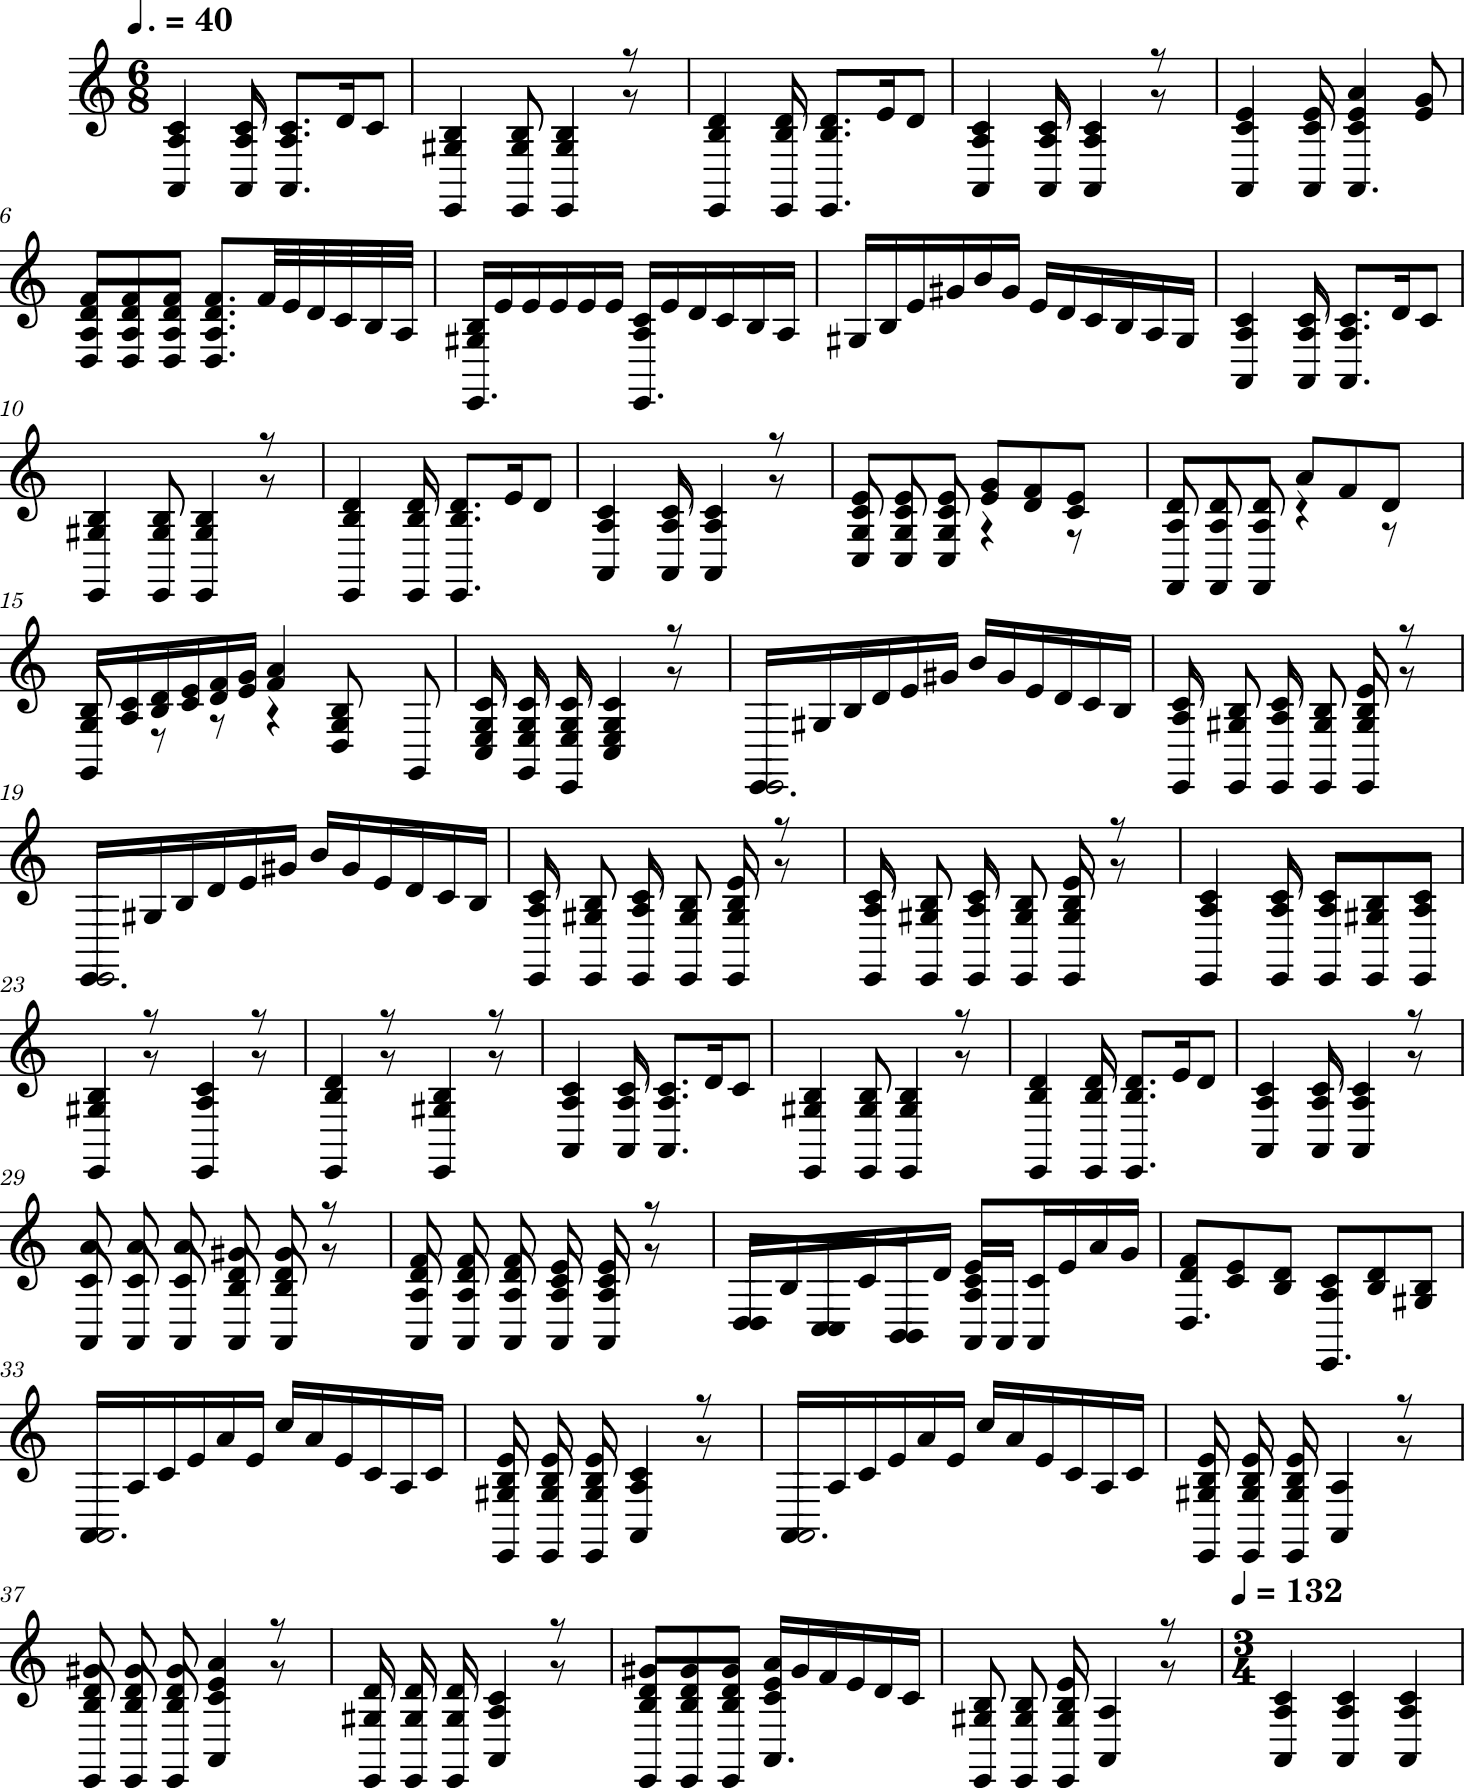

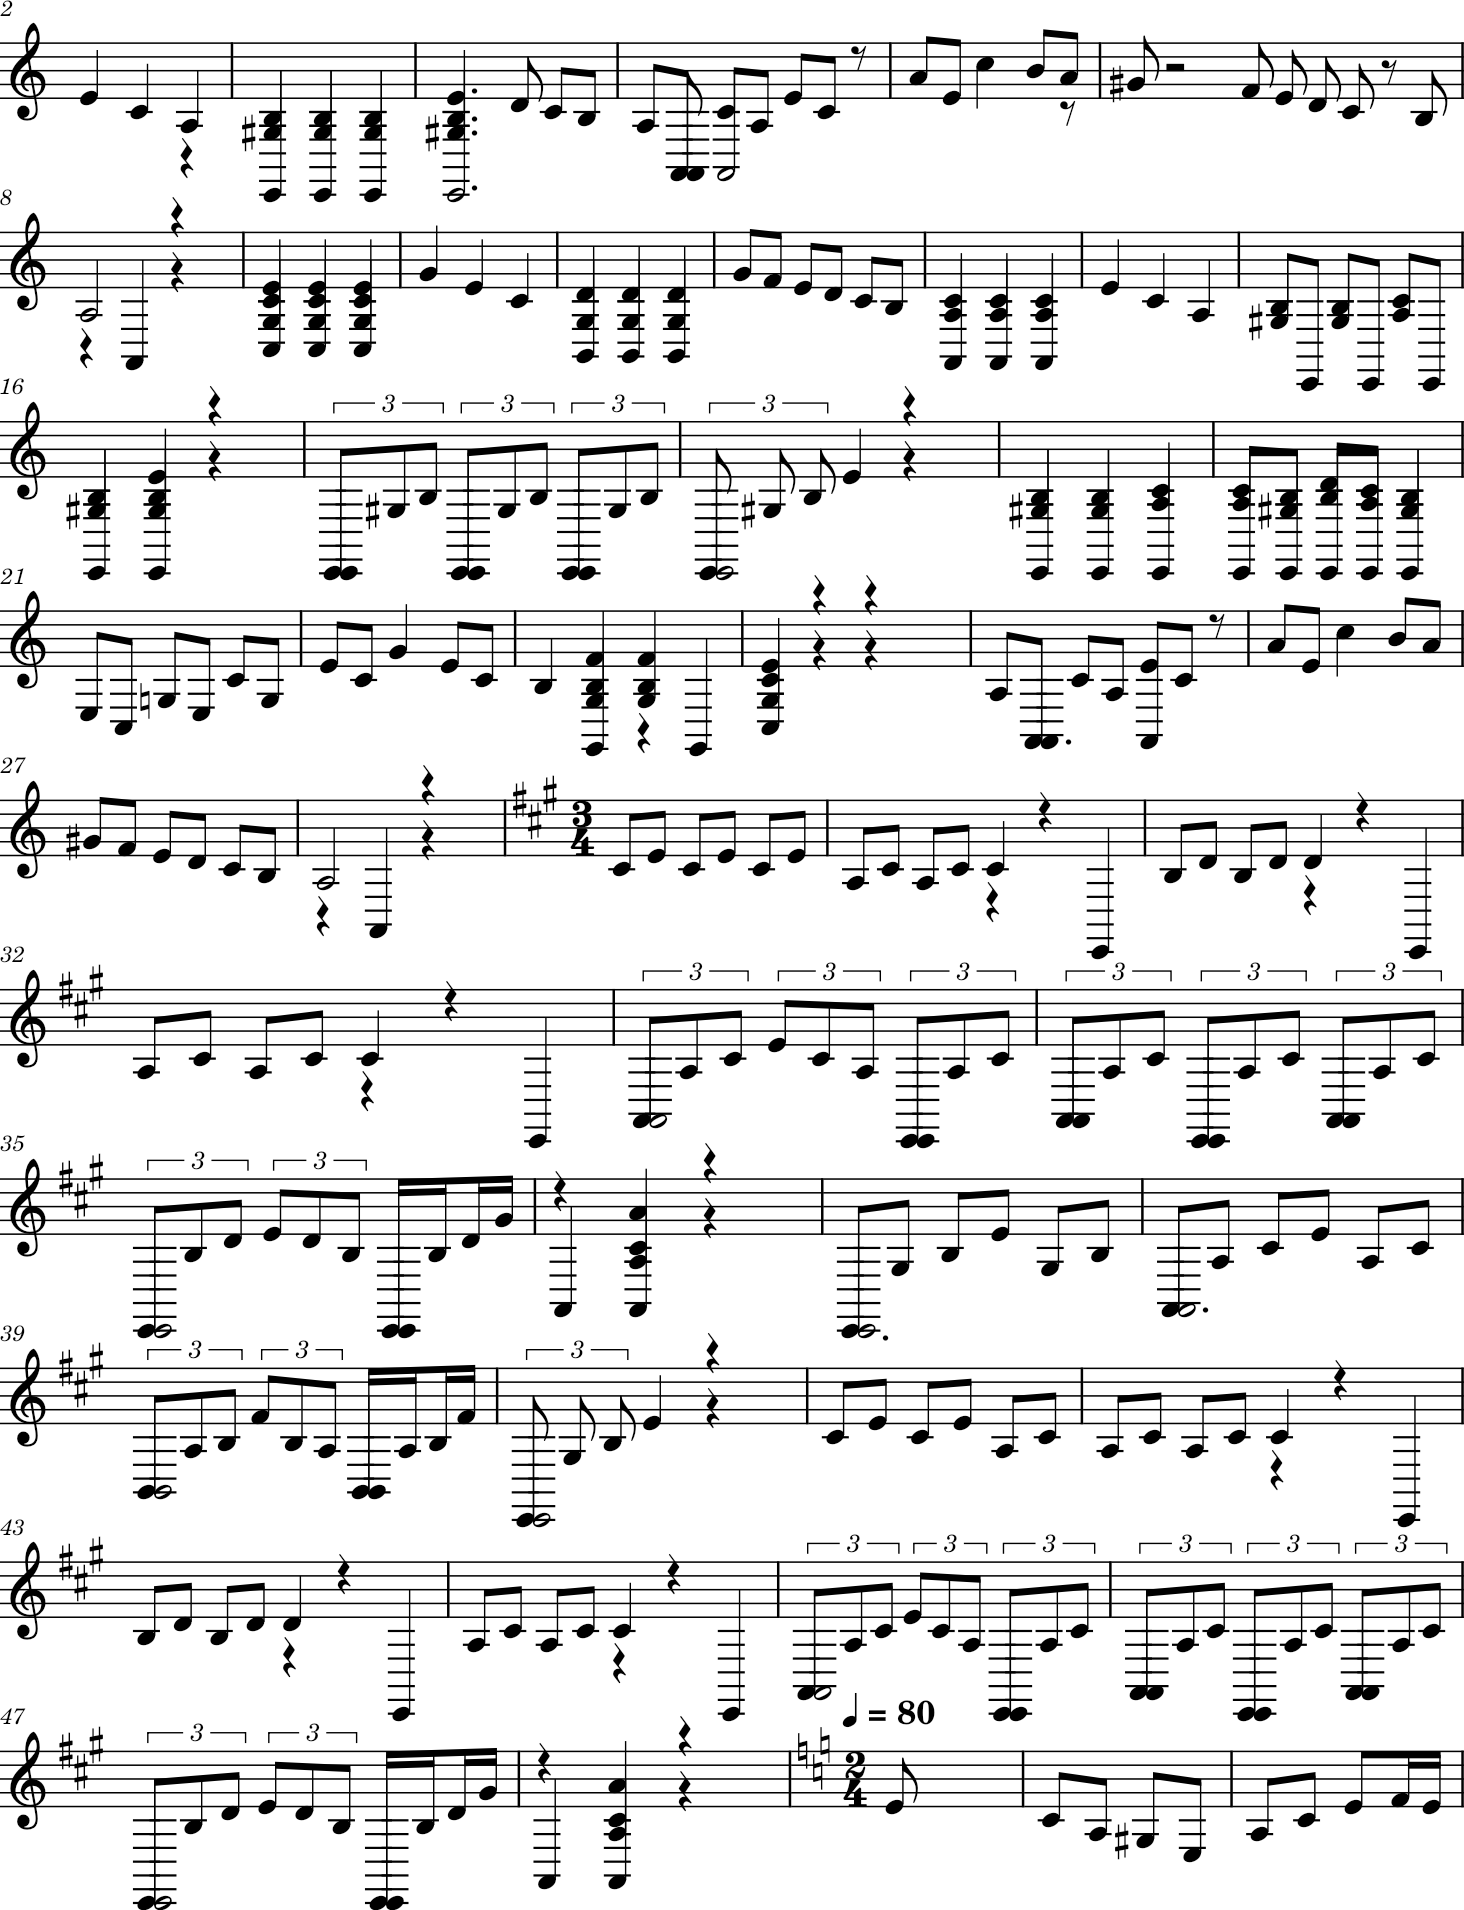

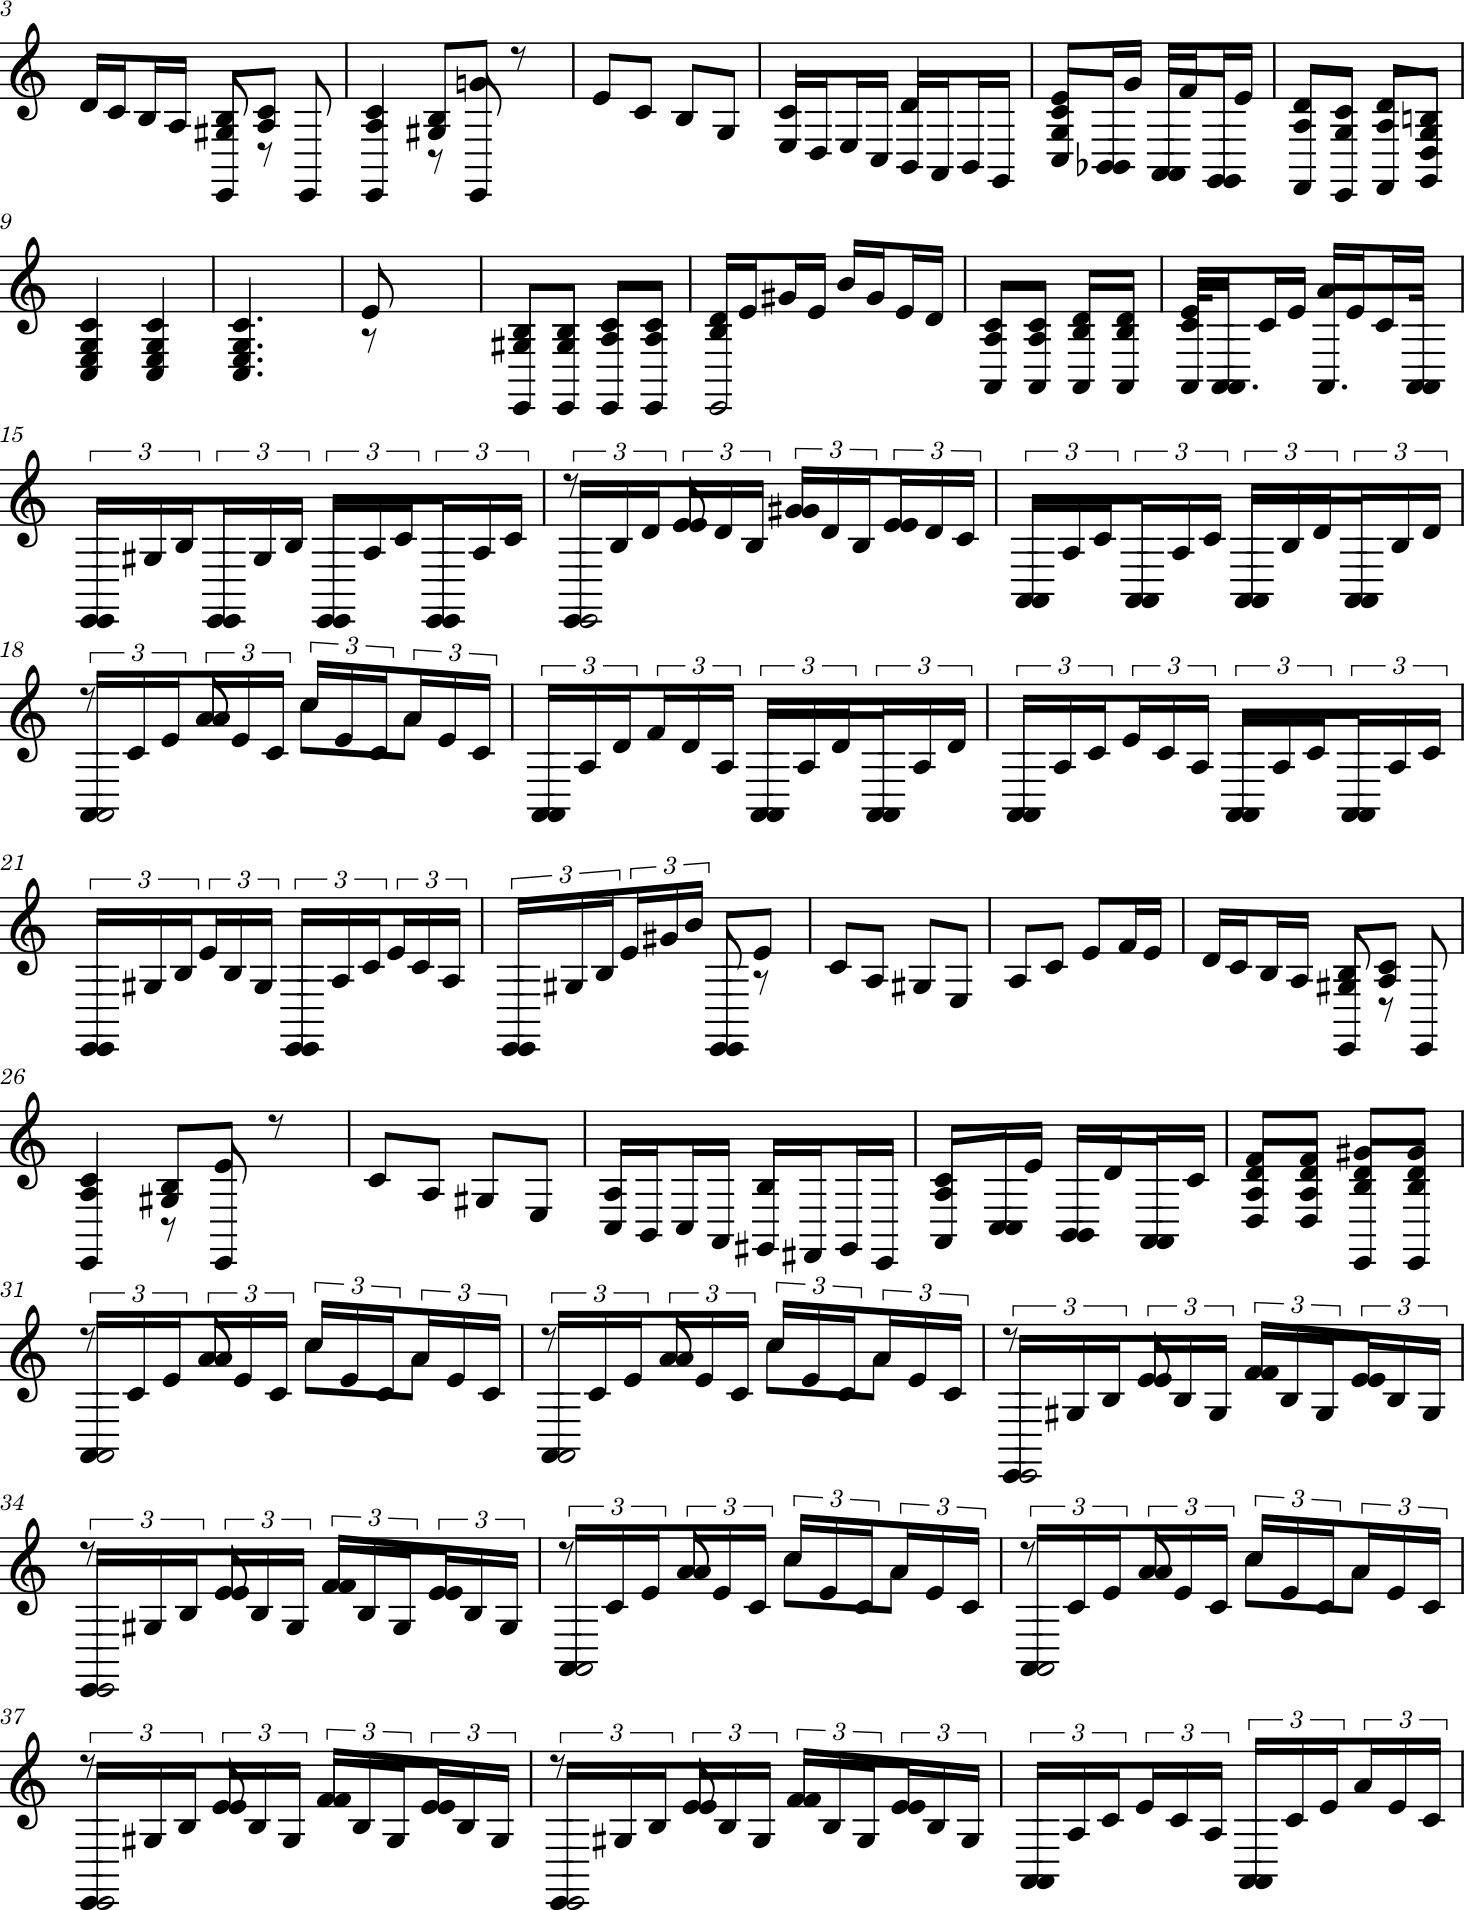

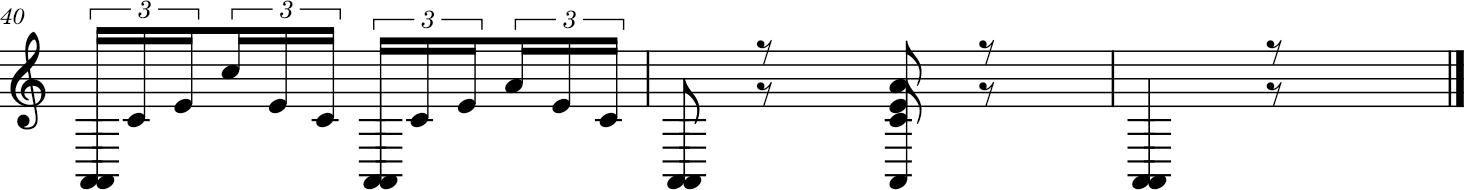


  Qmb2EEueDXEq8G6WdxQhmttjPrjQLMPpYm8kDTEBsYD2kR.mxl

--- ORIGINAL ---


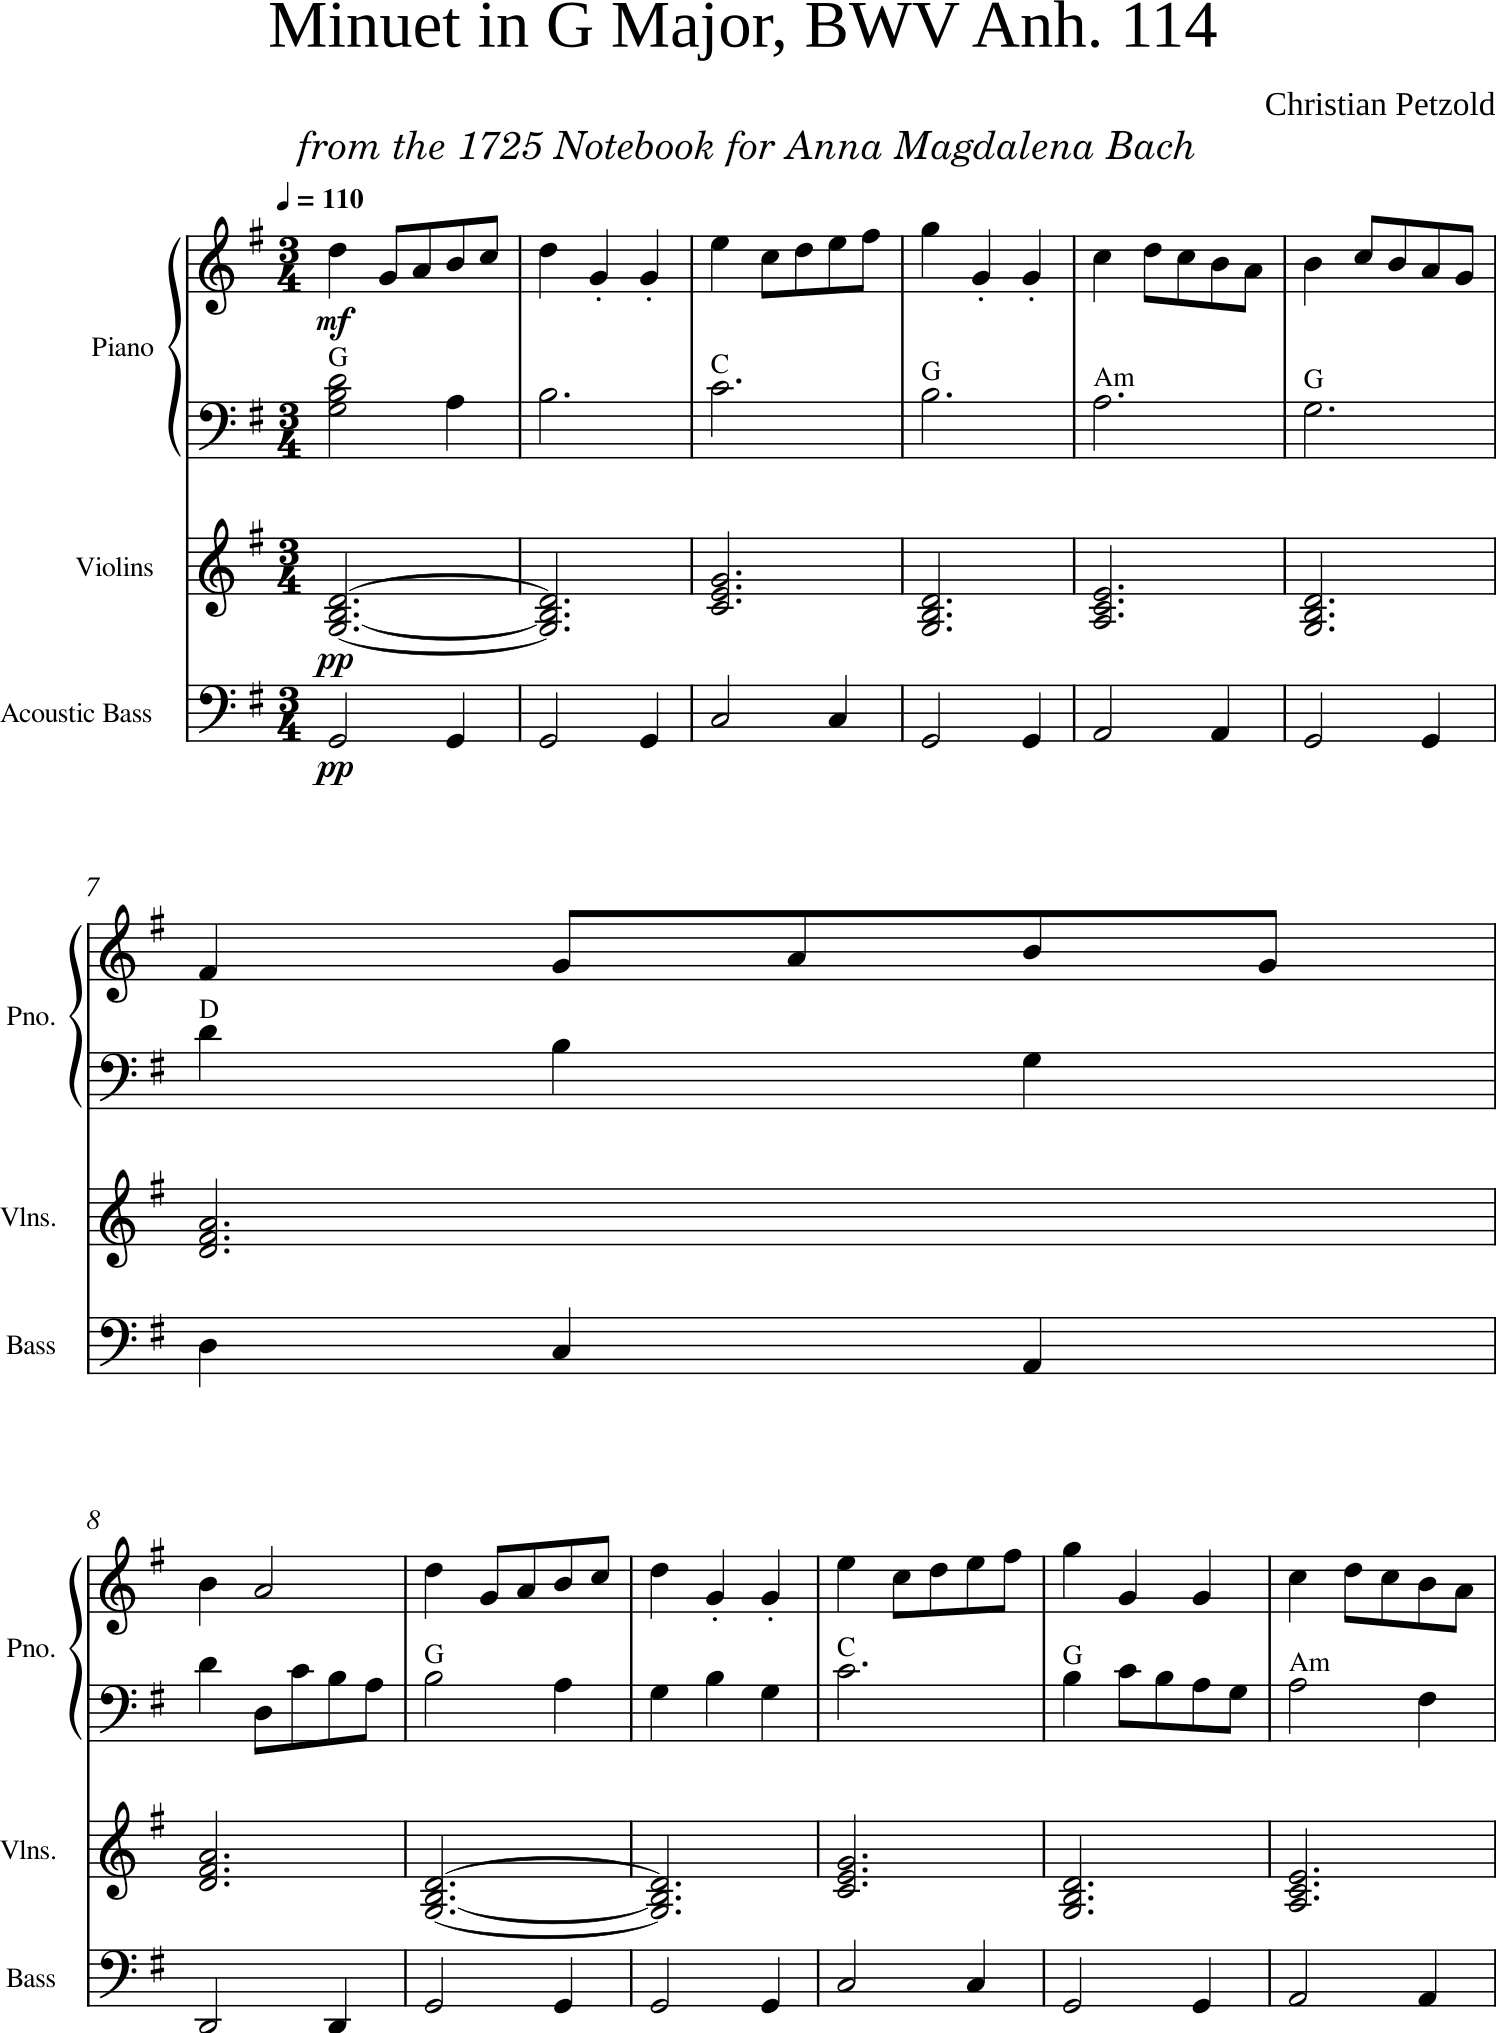

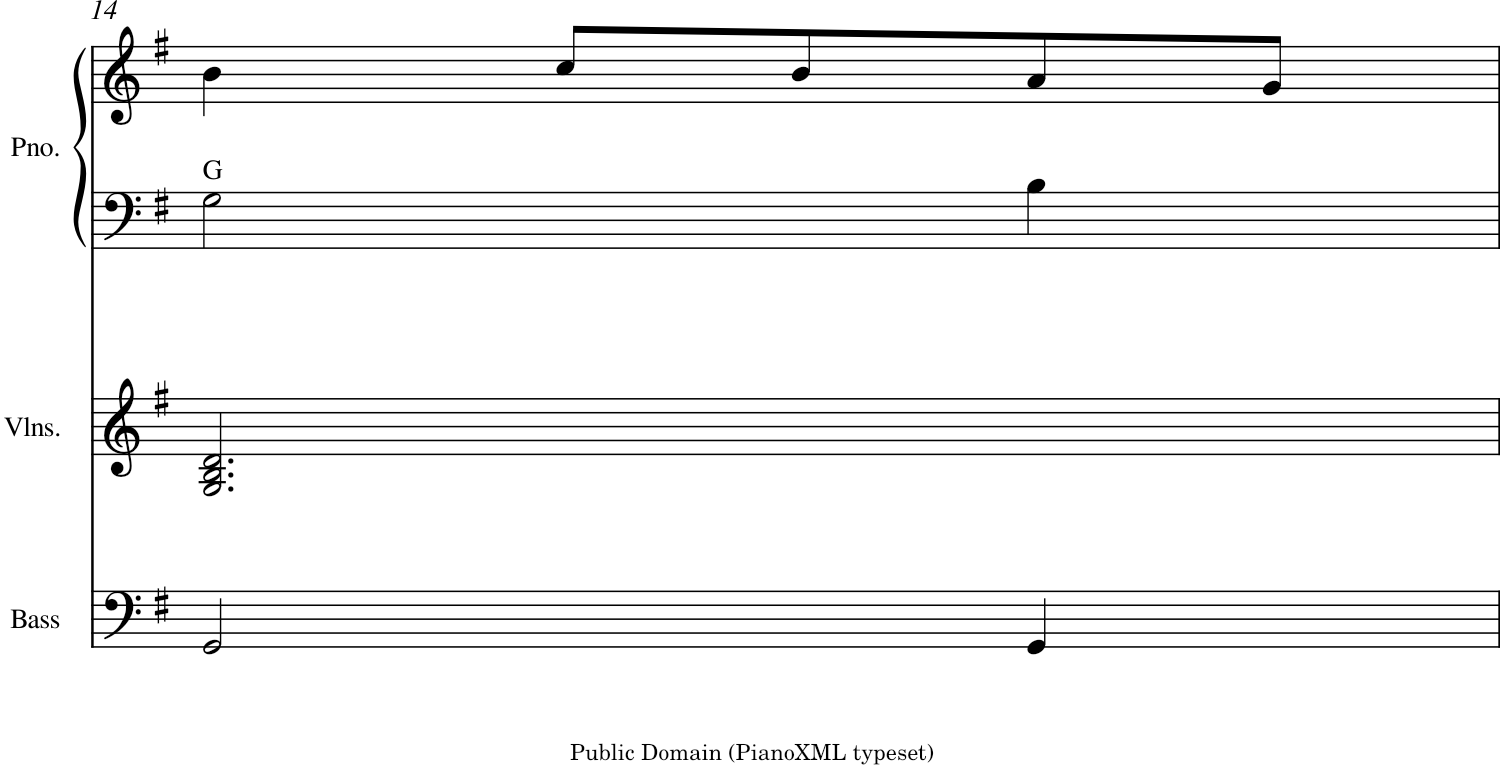

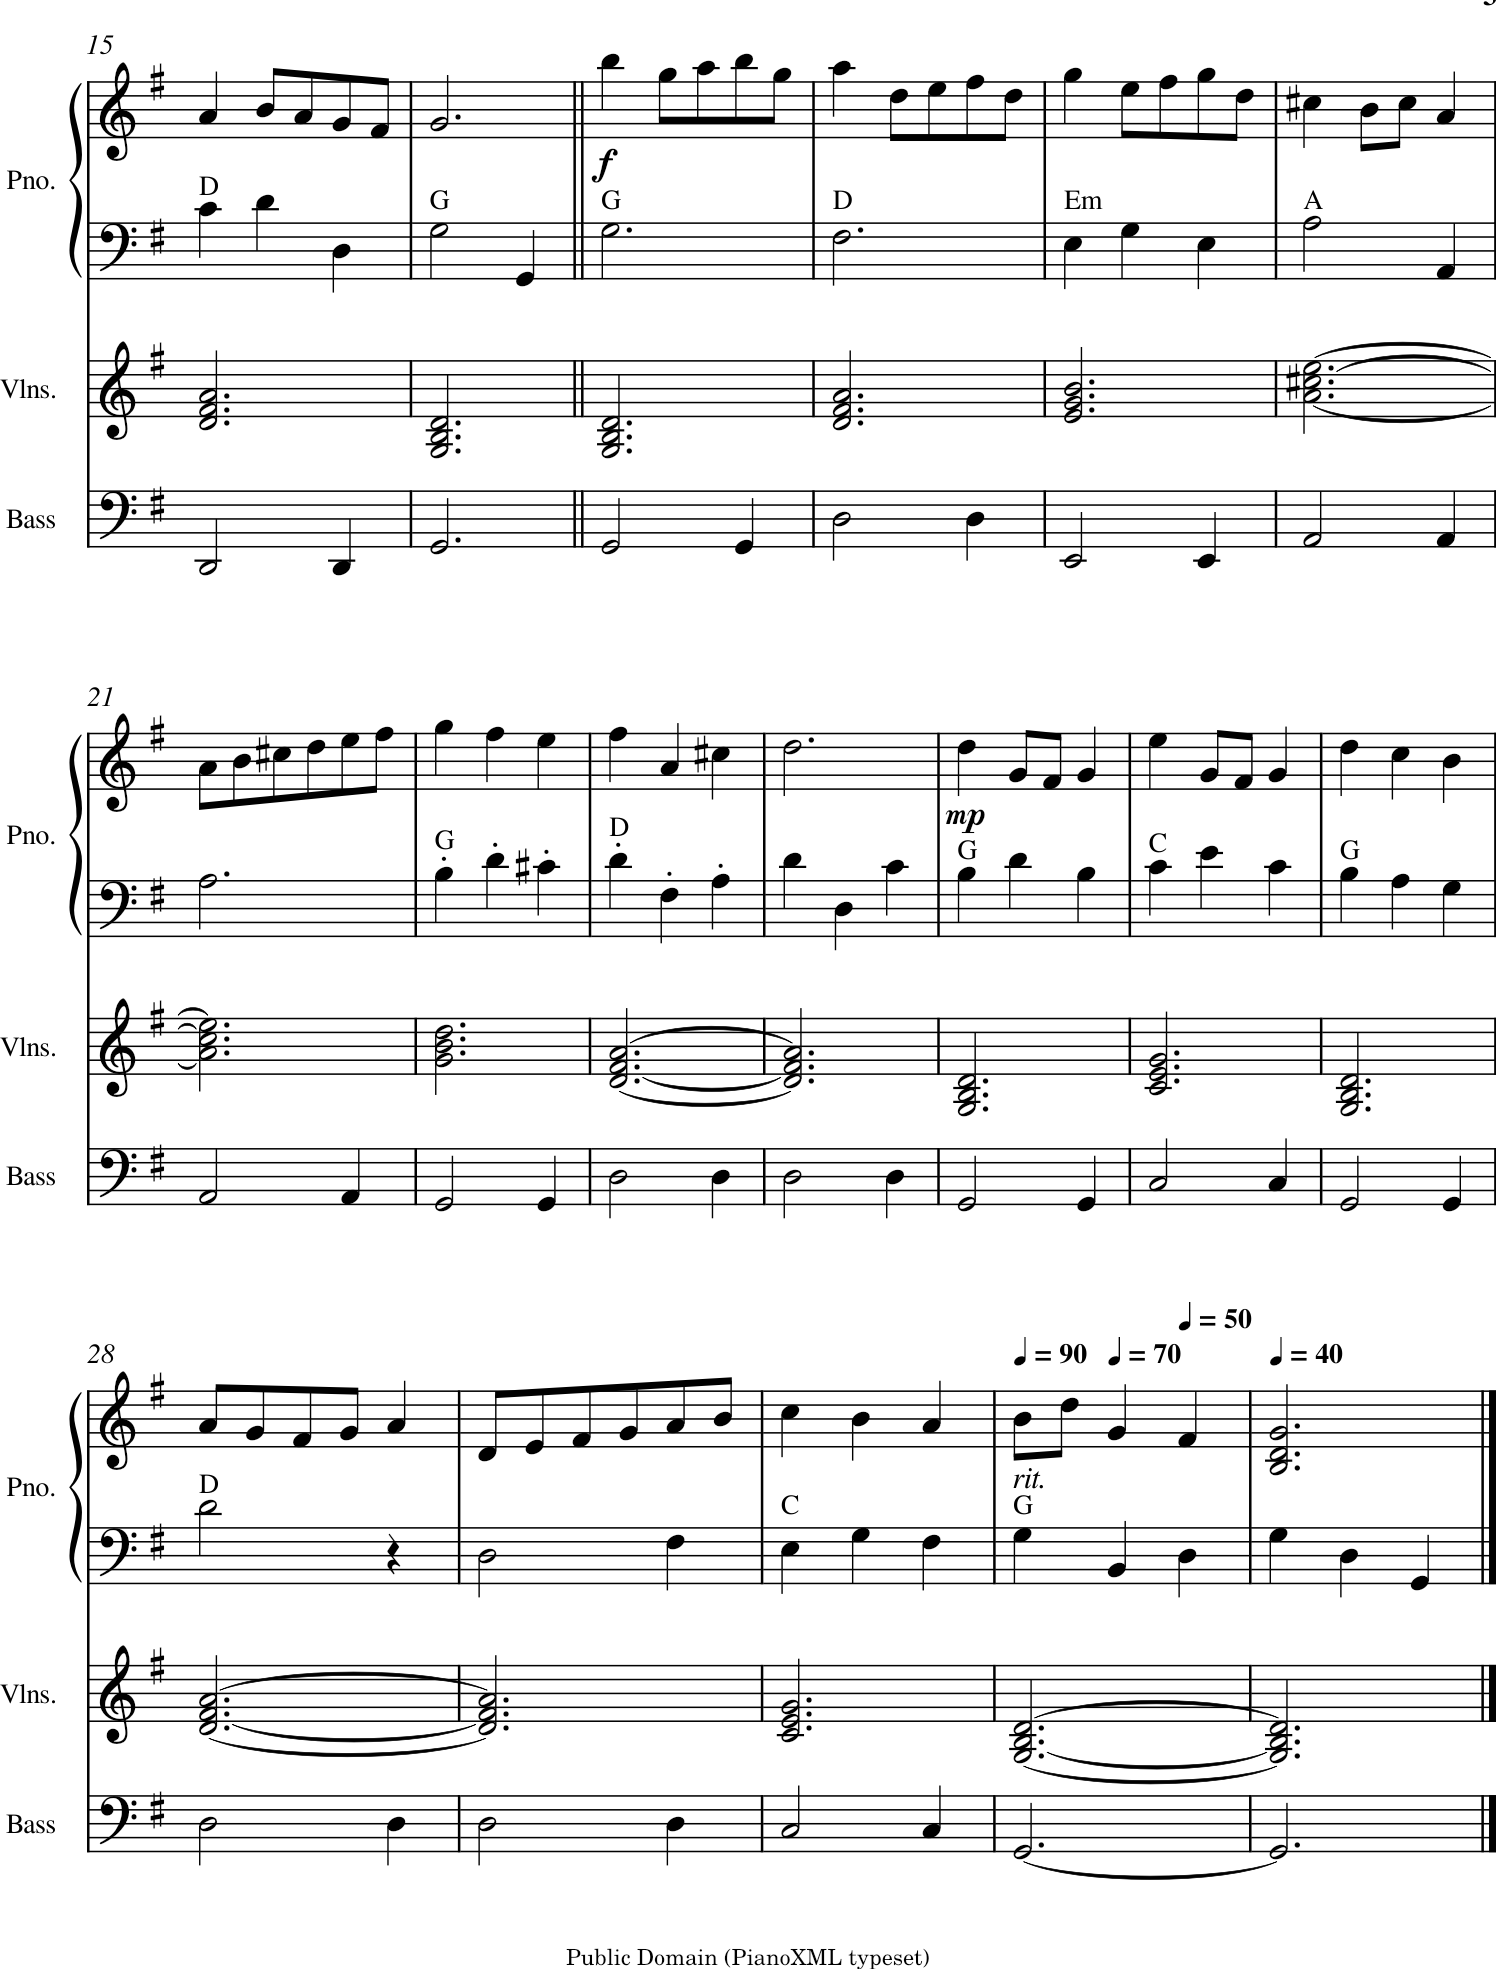


--- RECONSTRUCTED ---


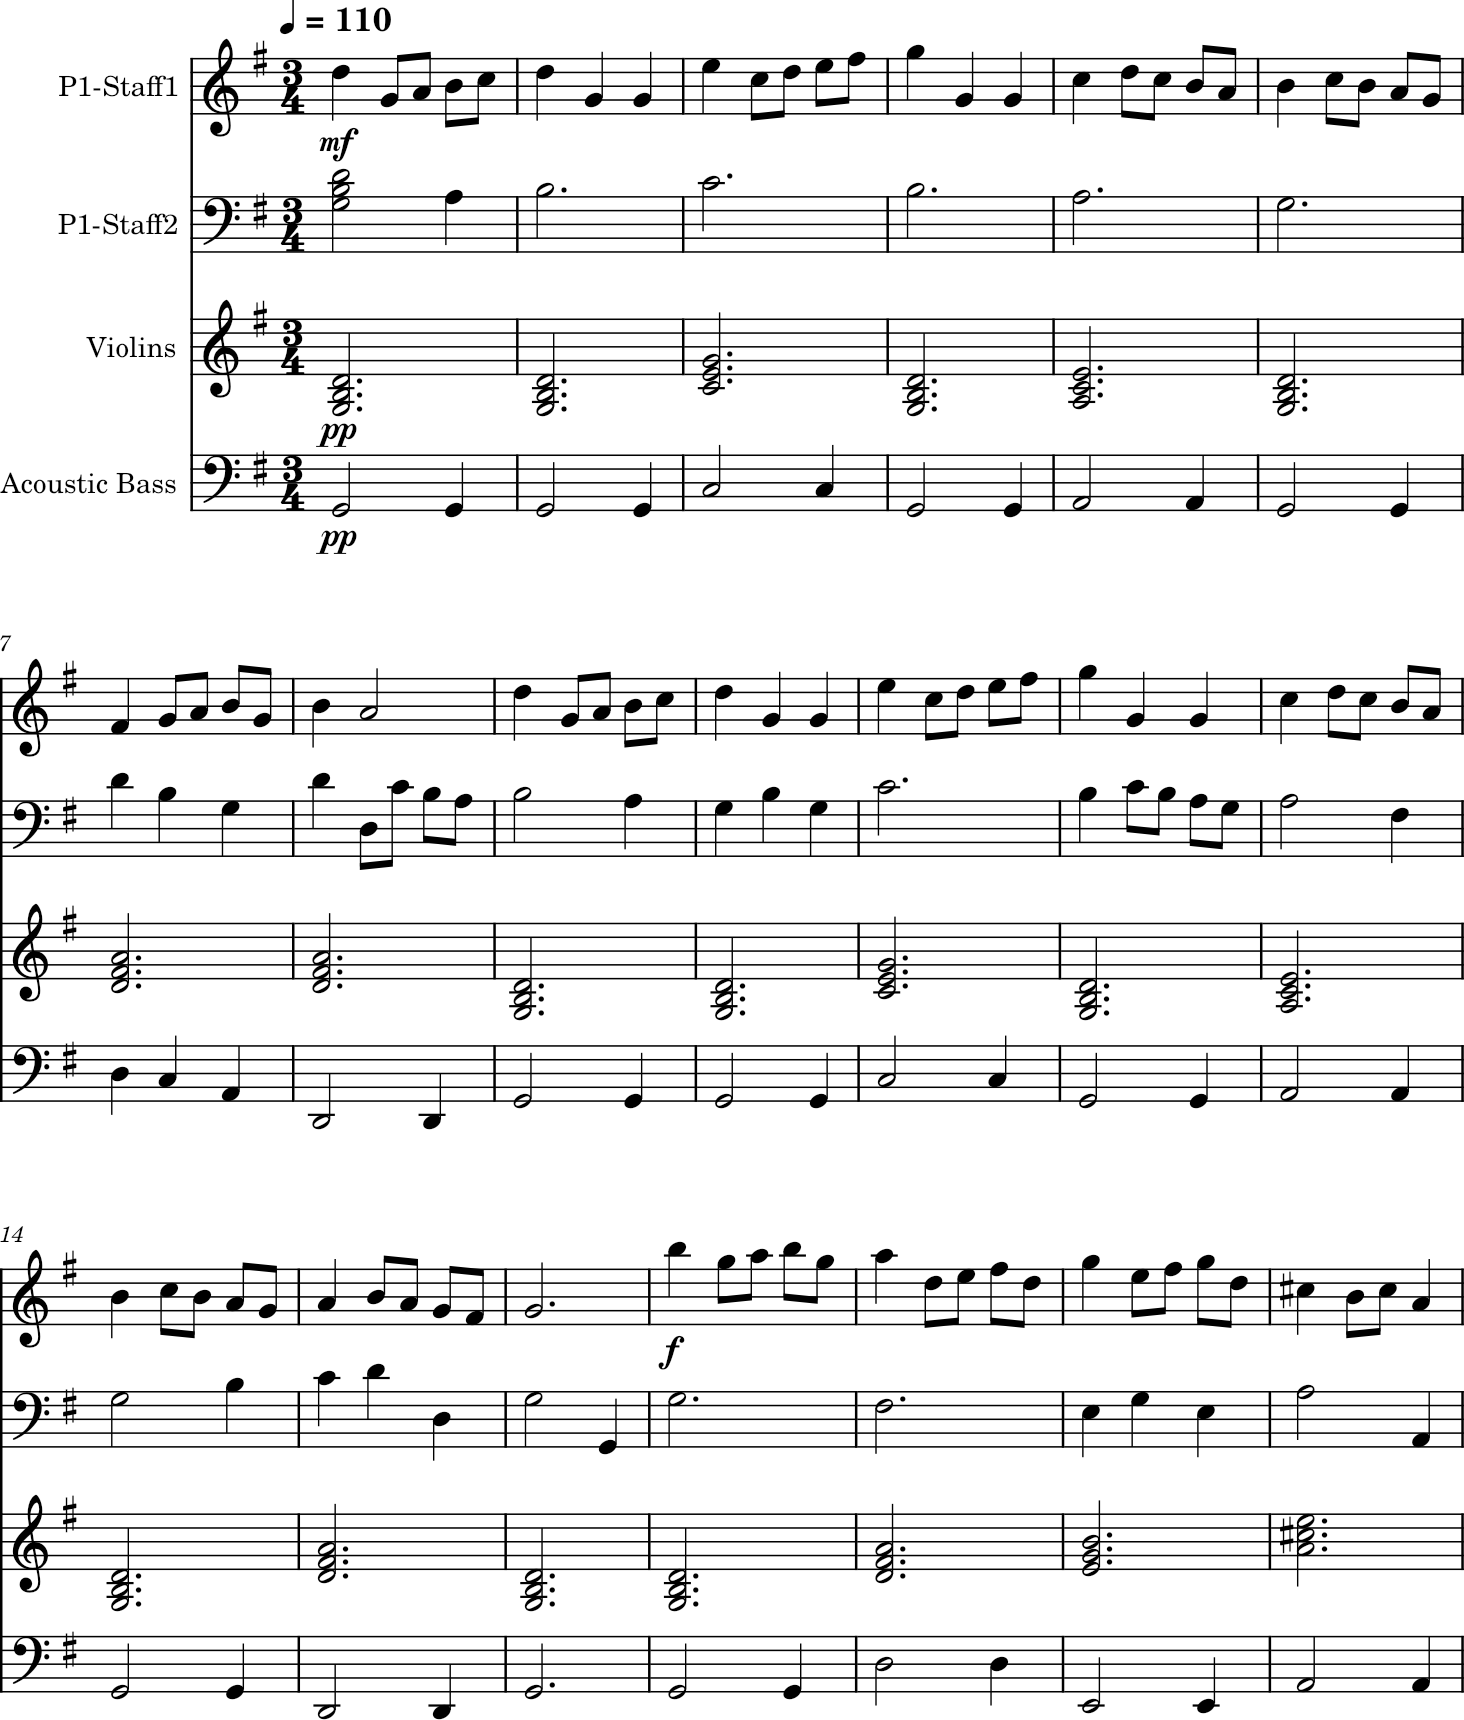

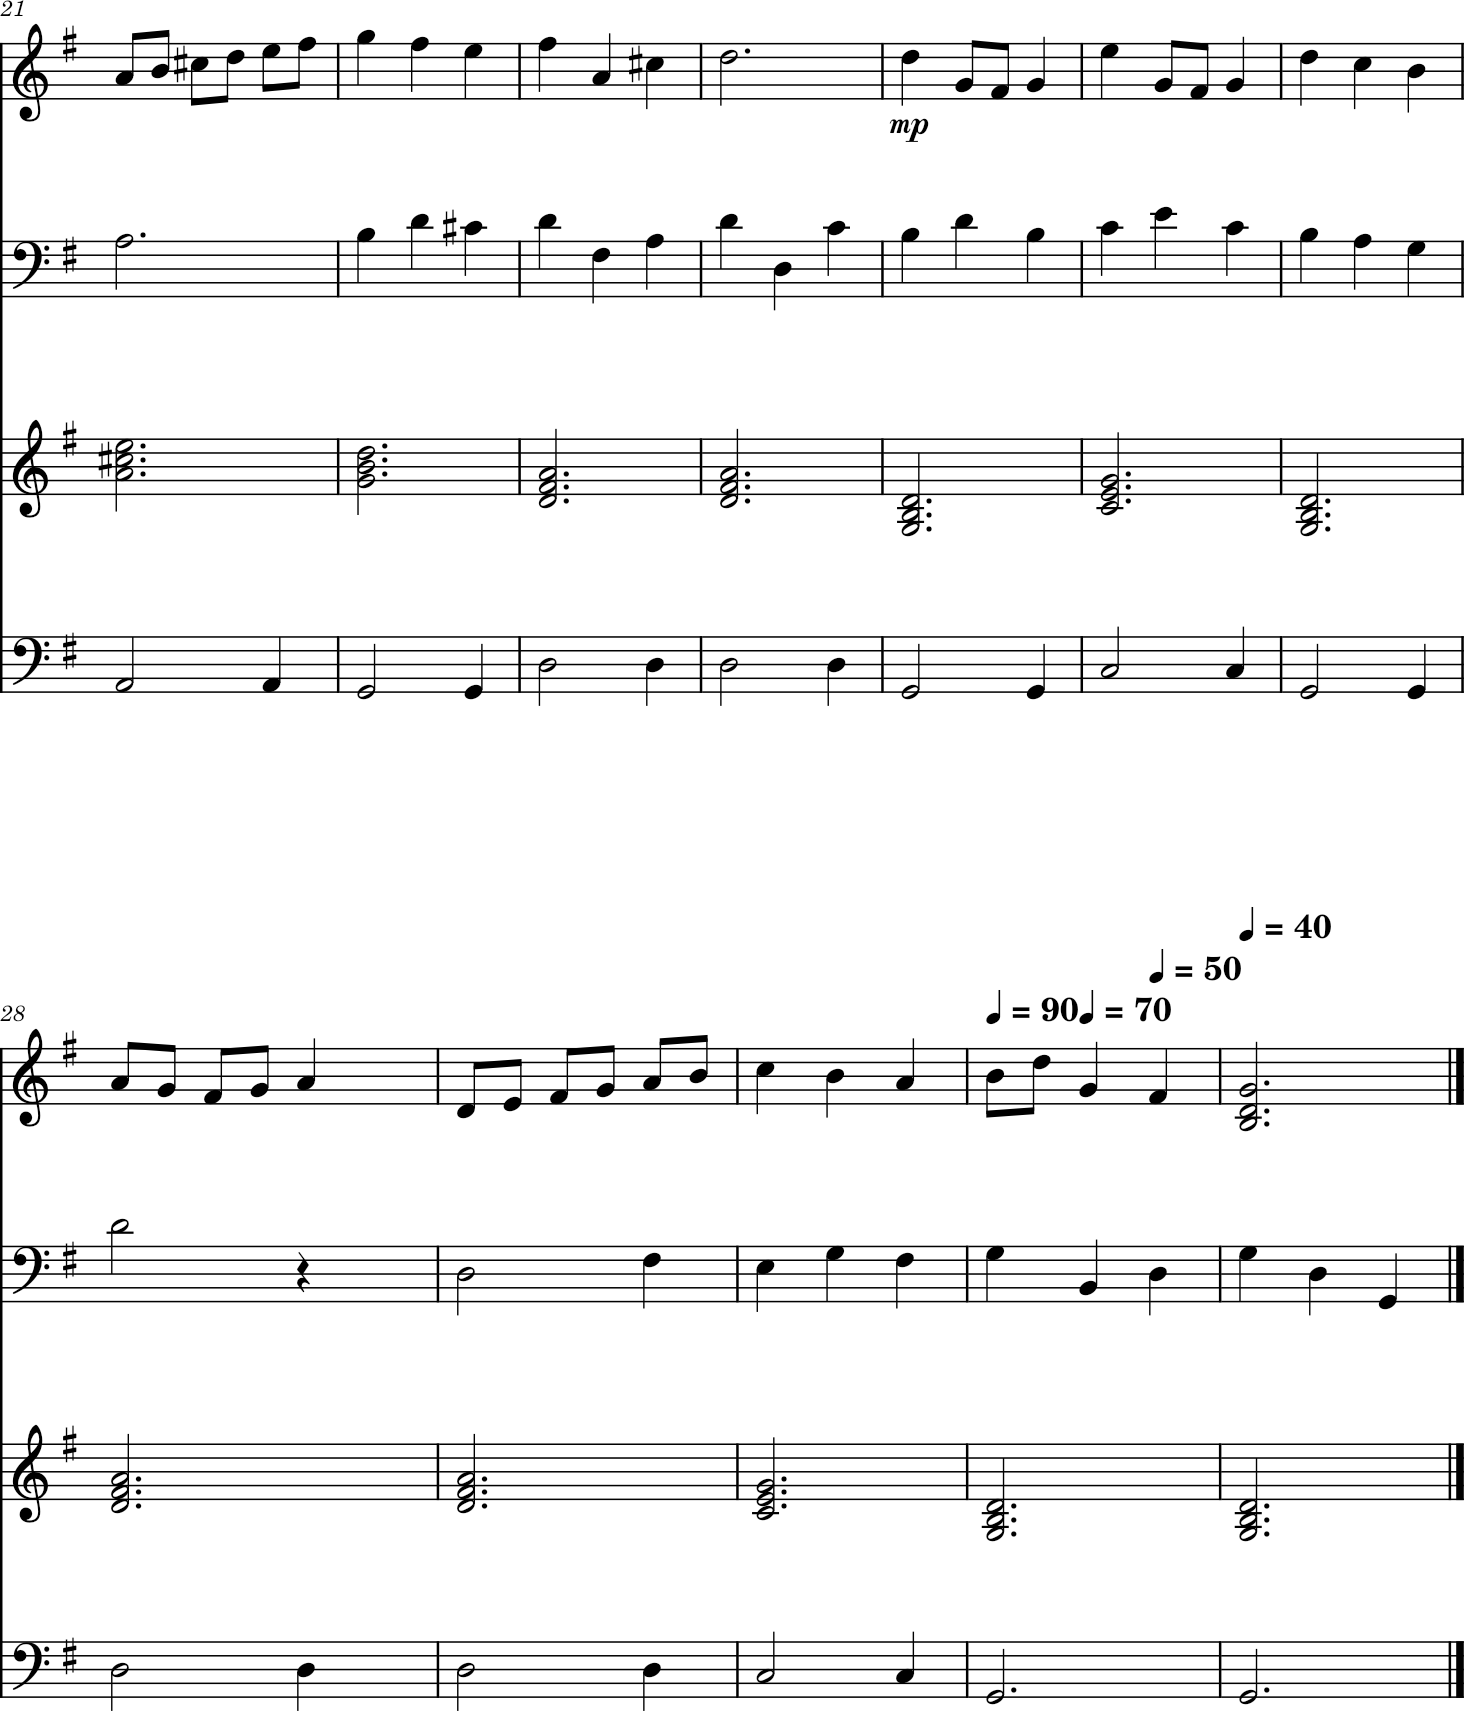


  Qmb2VvLHxqG5UQgWXT5DjmZytgUAuQWW359JavSjxaEton.mxl

--- ORIGINAL ---


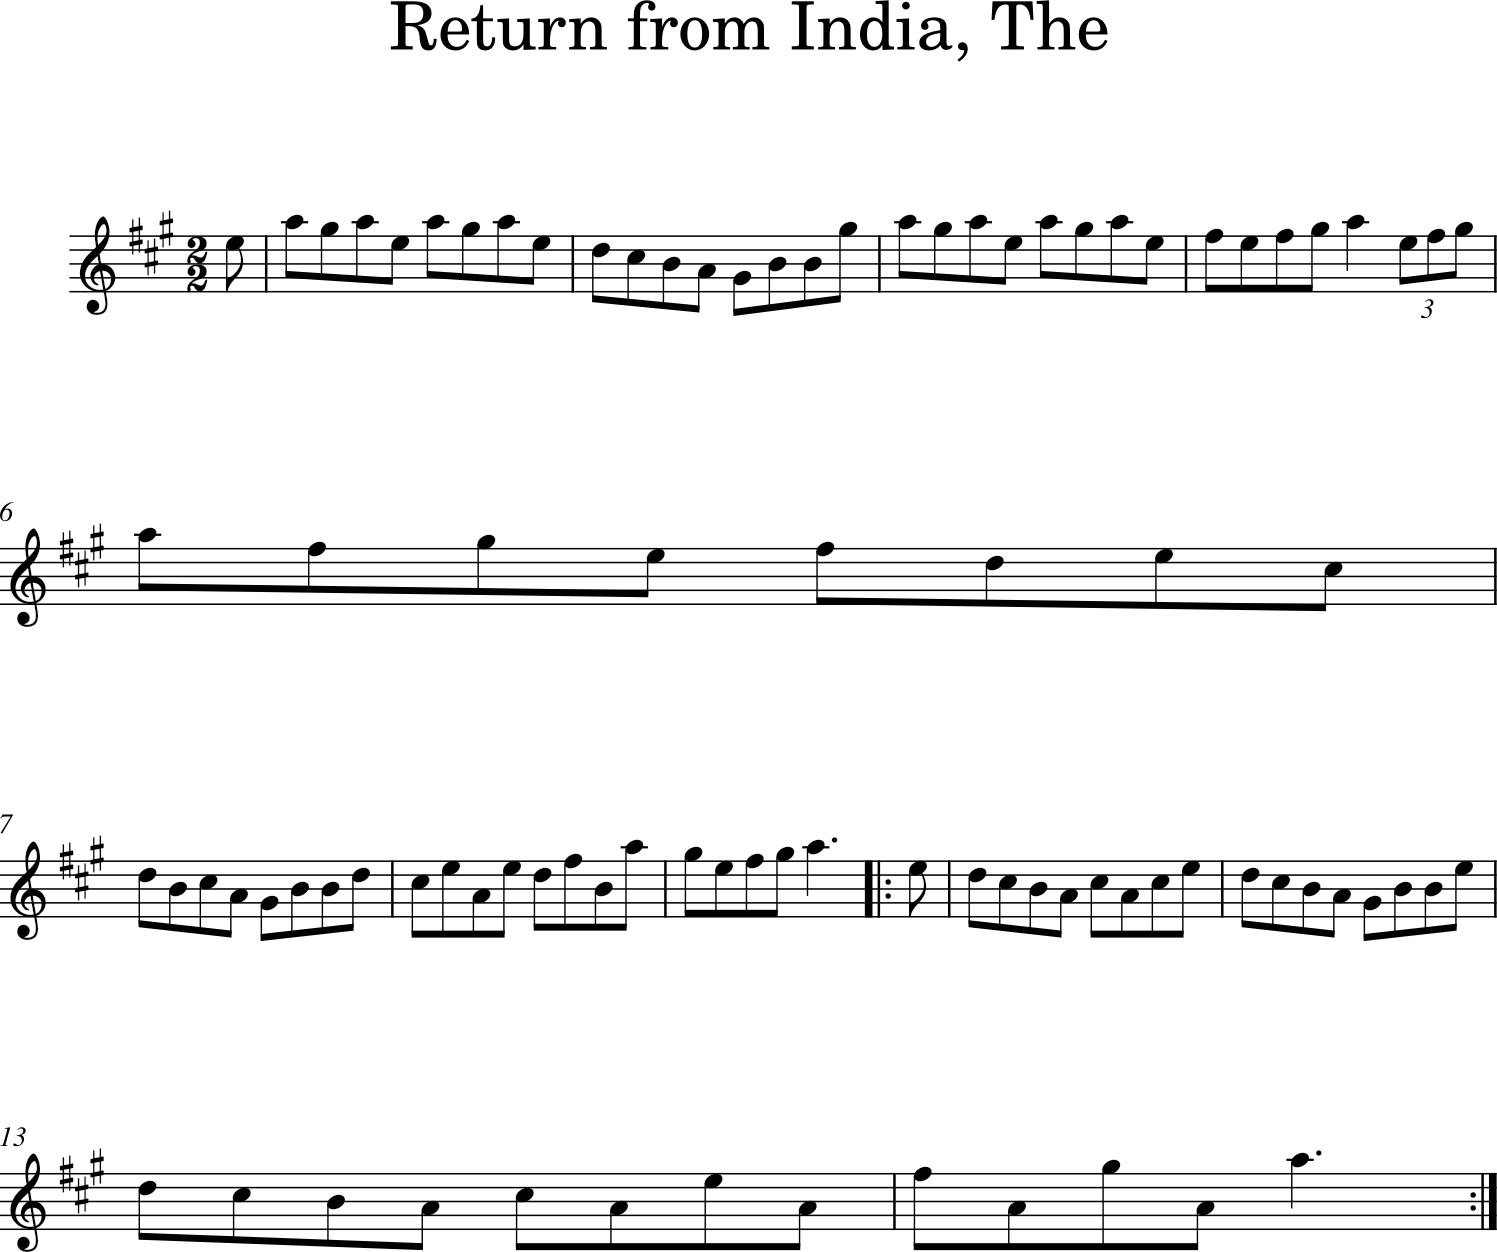


--- RECONSTRUCTED ---


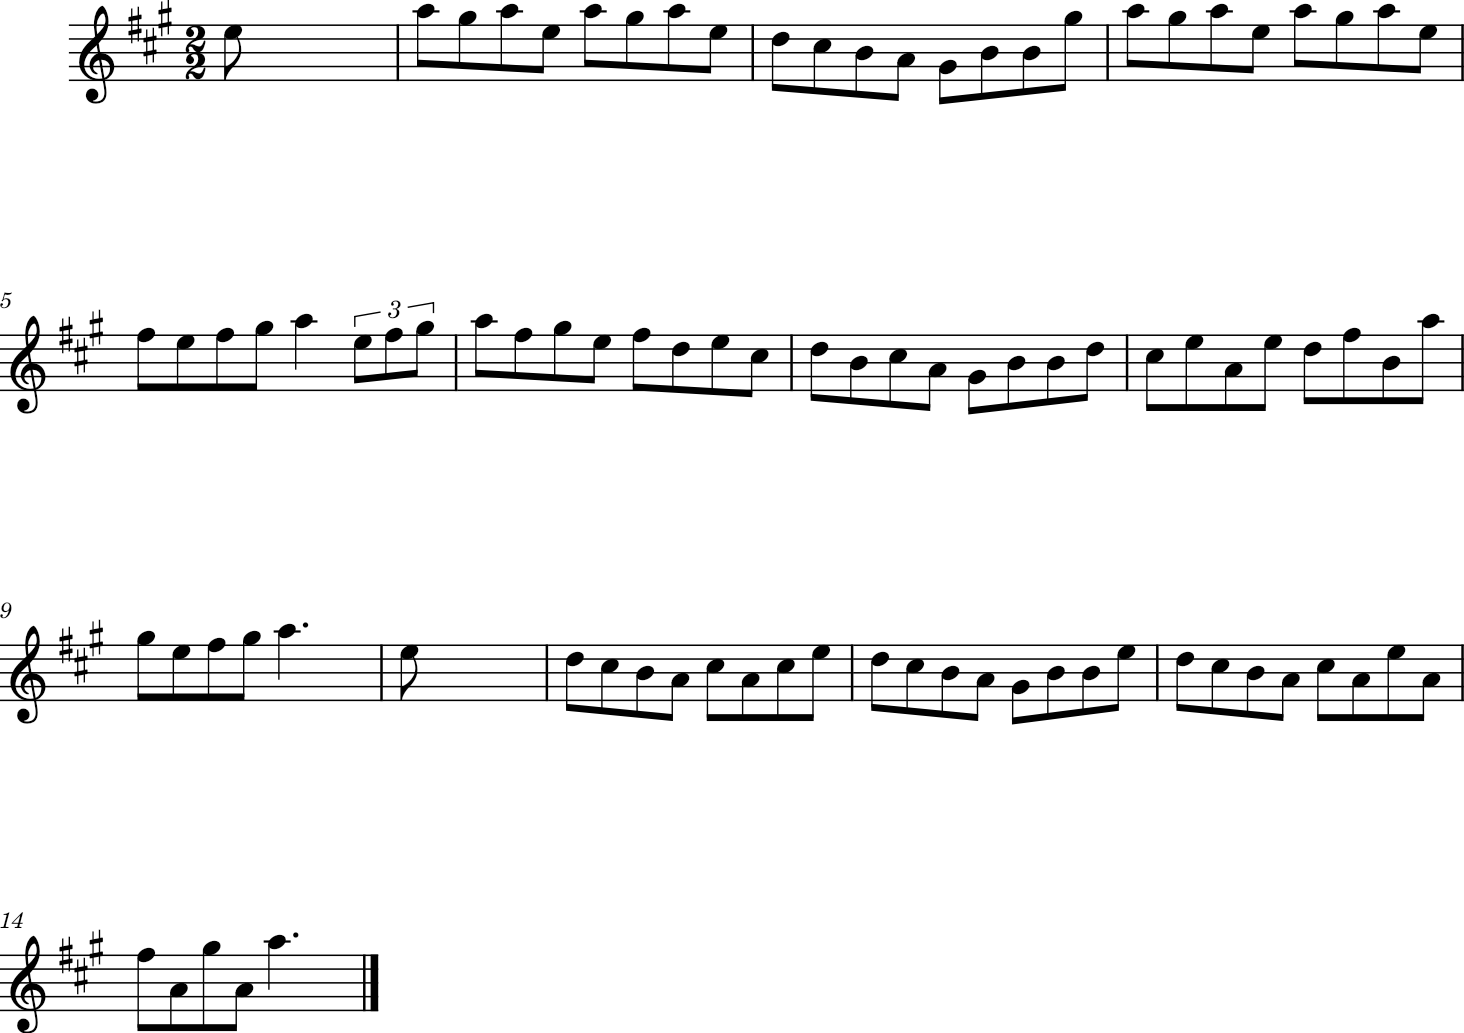


  Qmb2a9Fva12WXodCP6drWC8GsvhEf8ev3LUCpWMFWfEfzR.mxl

--- ORIGINAL ---


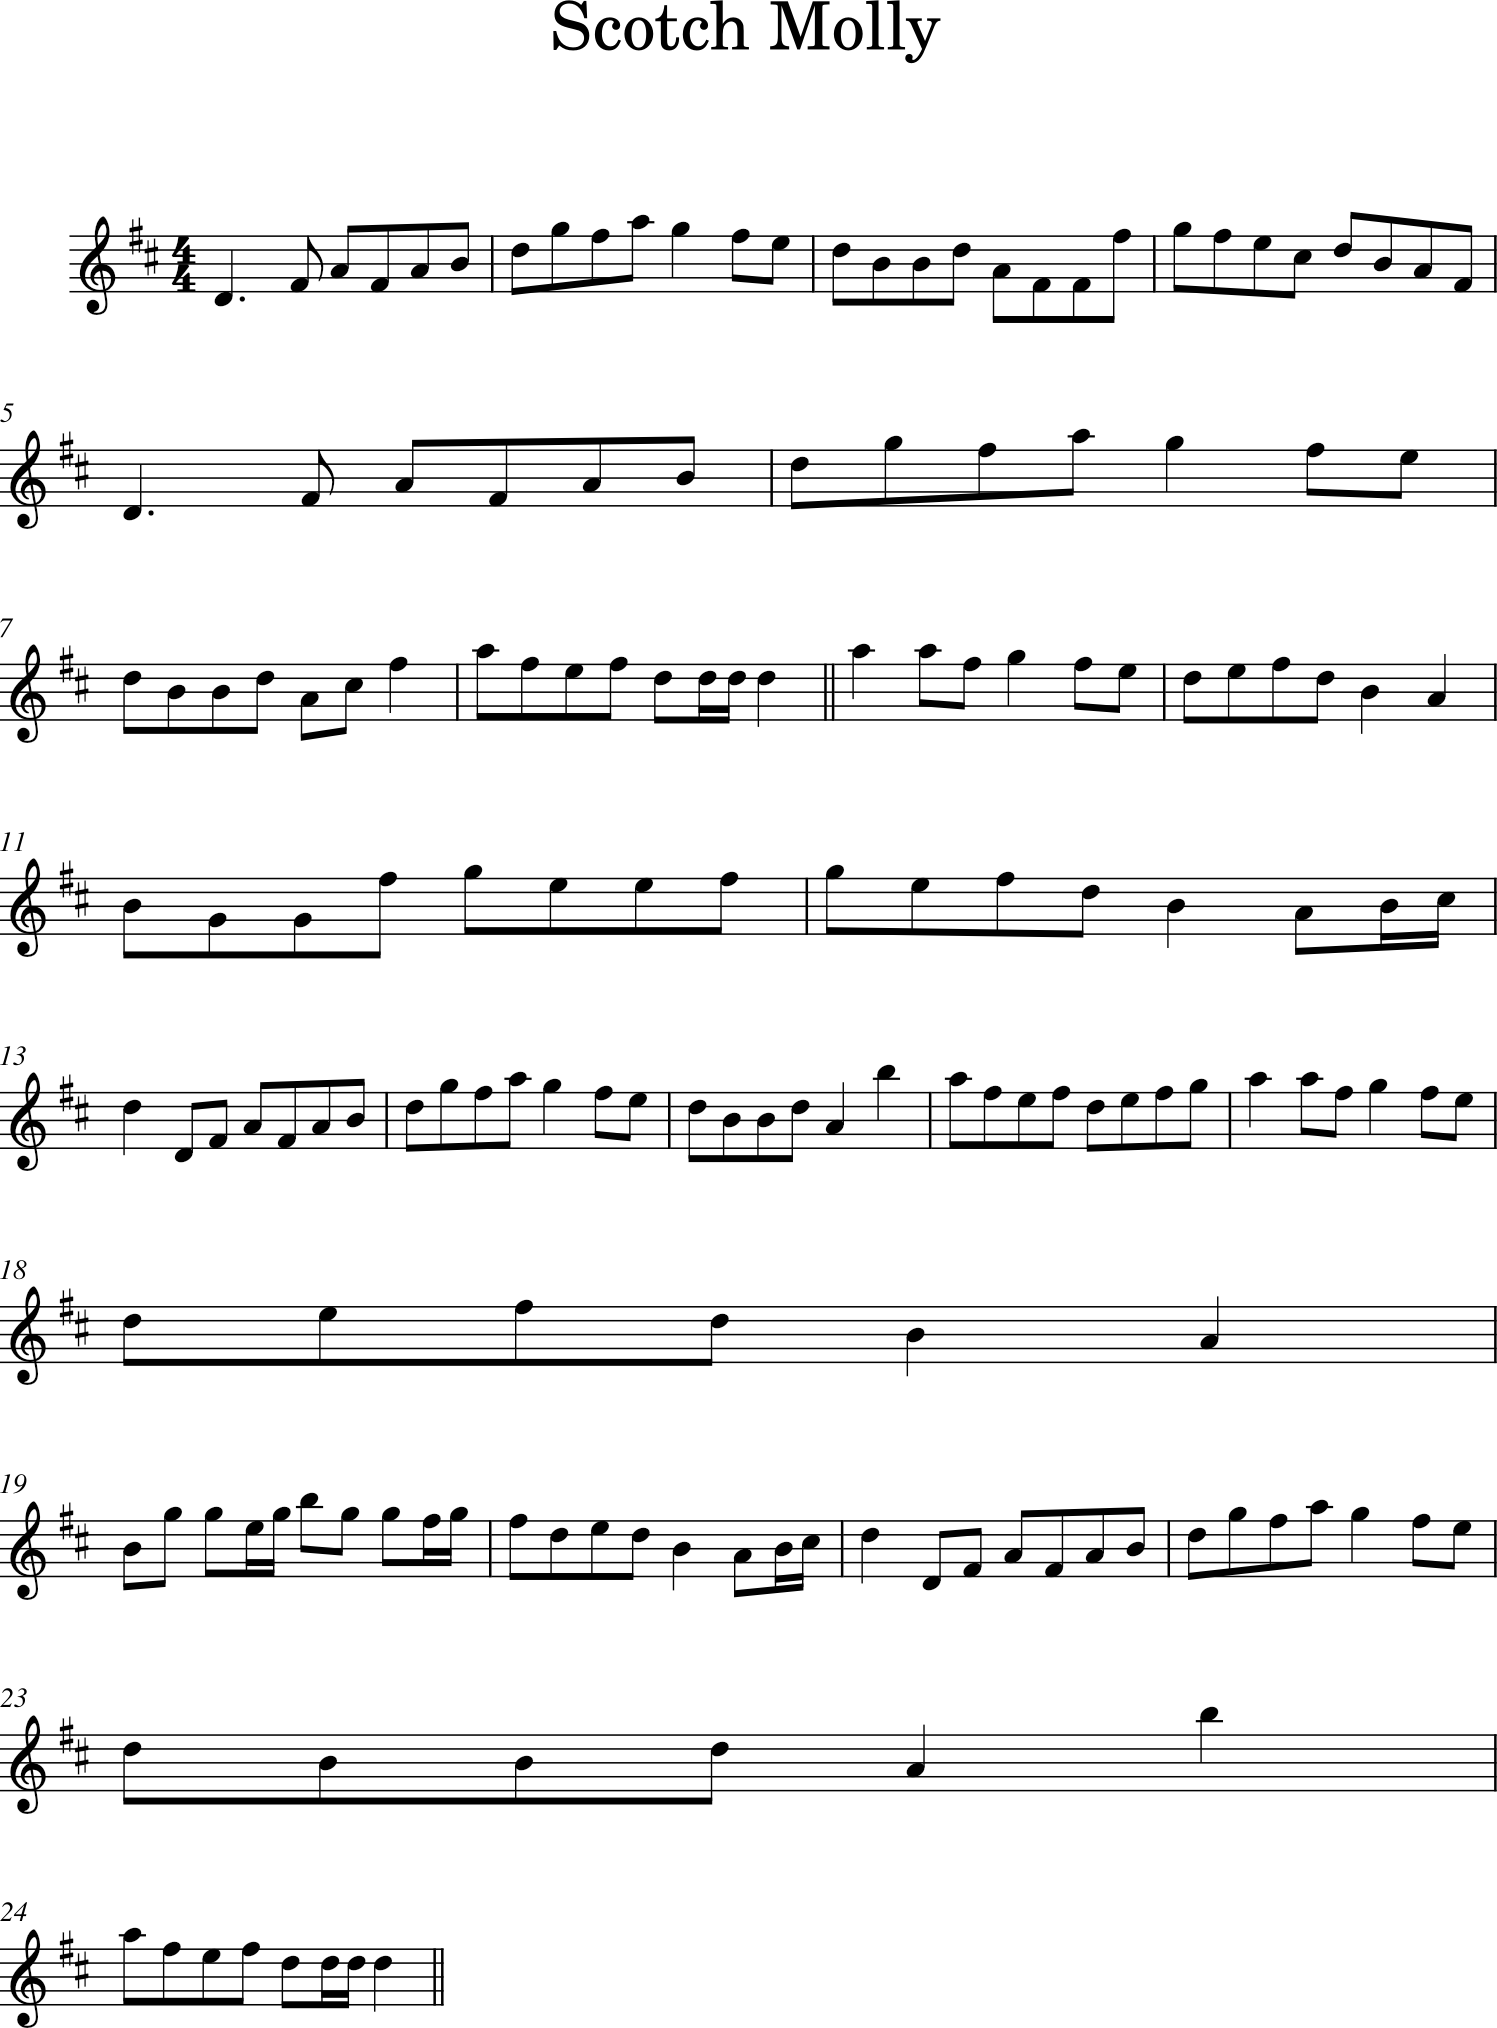


--- RECONSTRUCTED ---


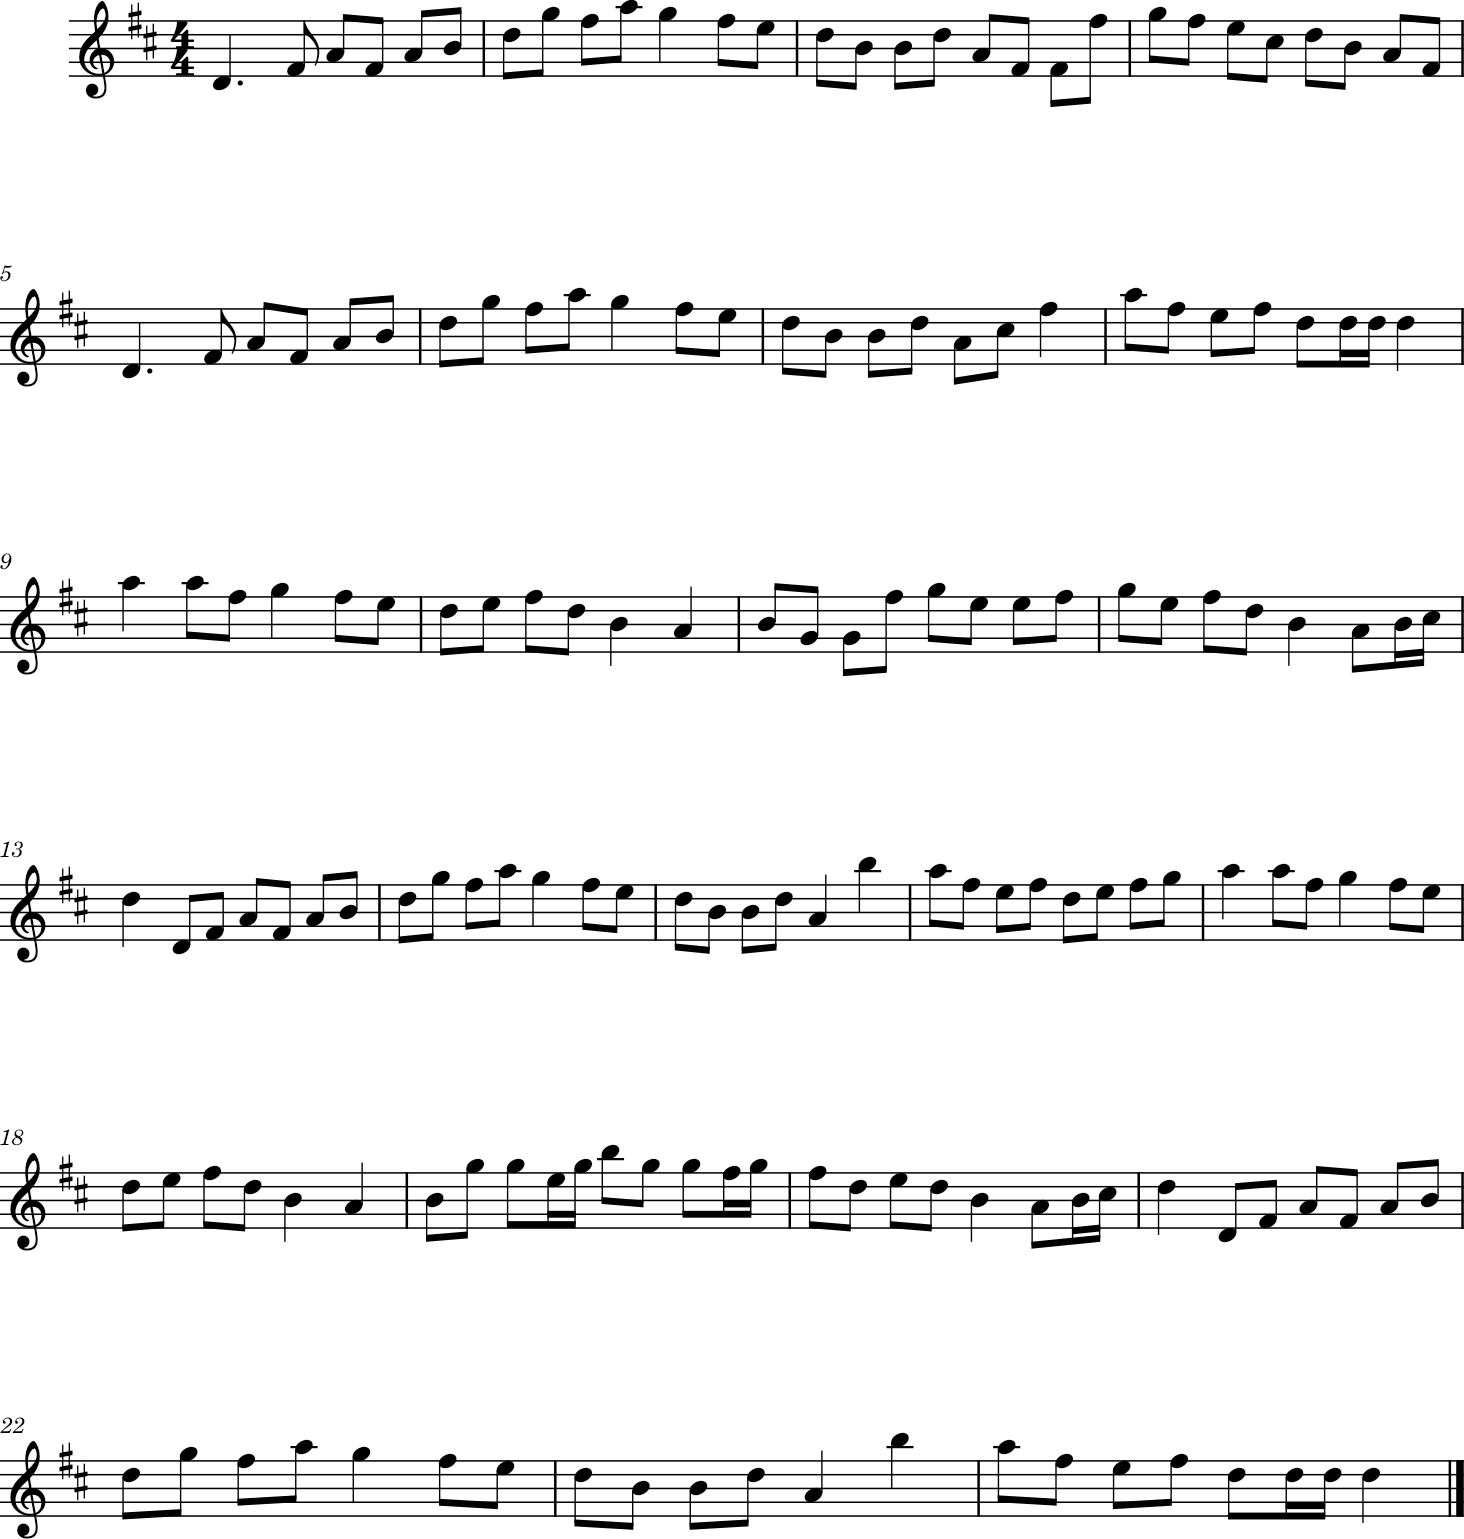


  Qmb2d6ptFFaeCxUJJiPLzXPKXJZgwGYLk2r9U7aBpL1rmC.mxl

--- ORIGINAL ---


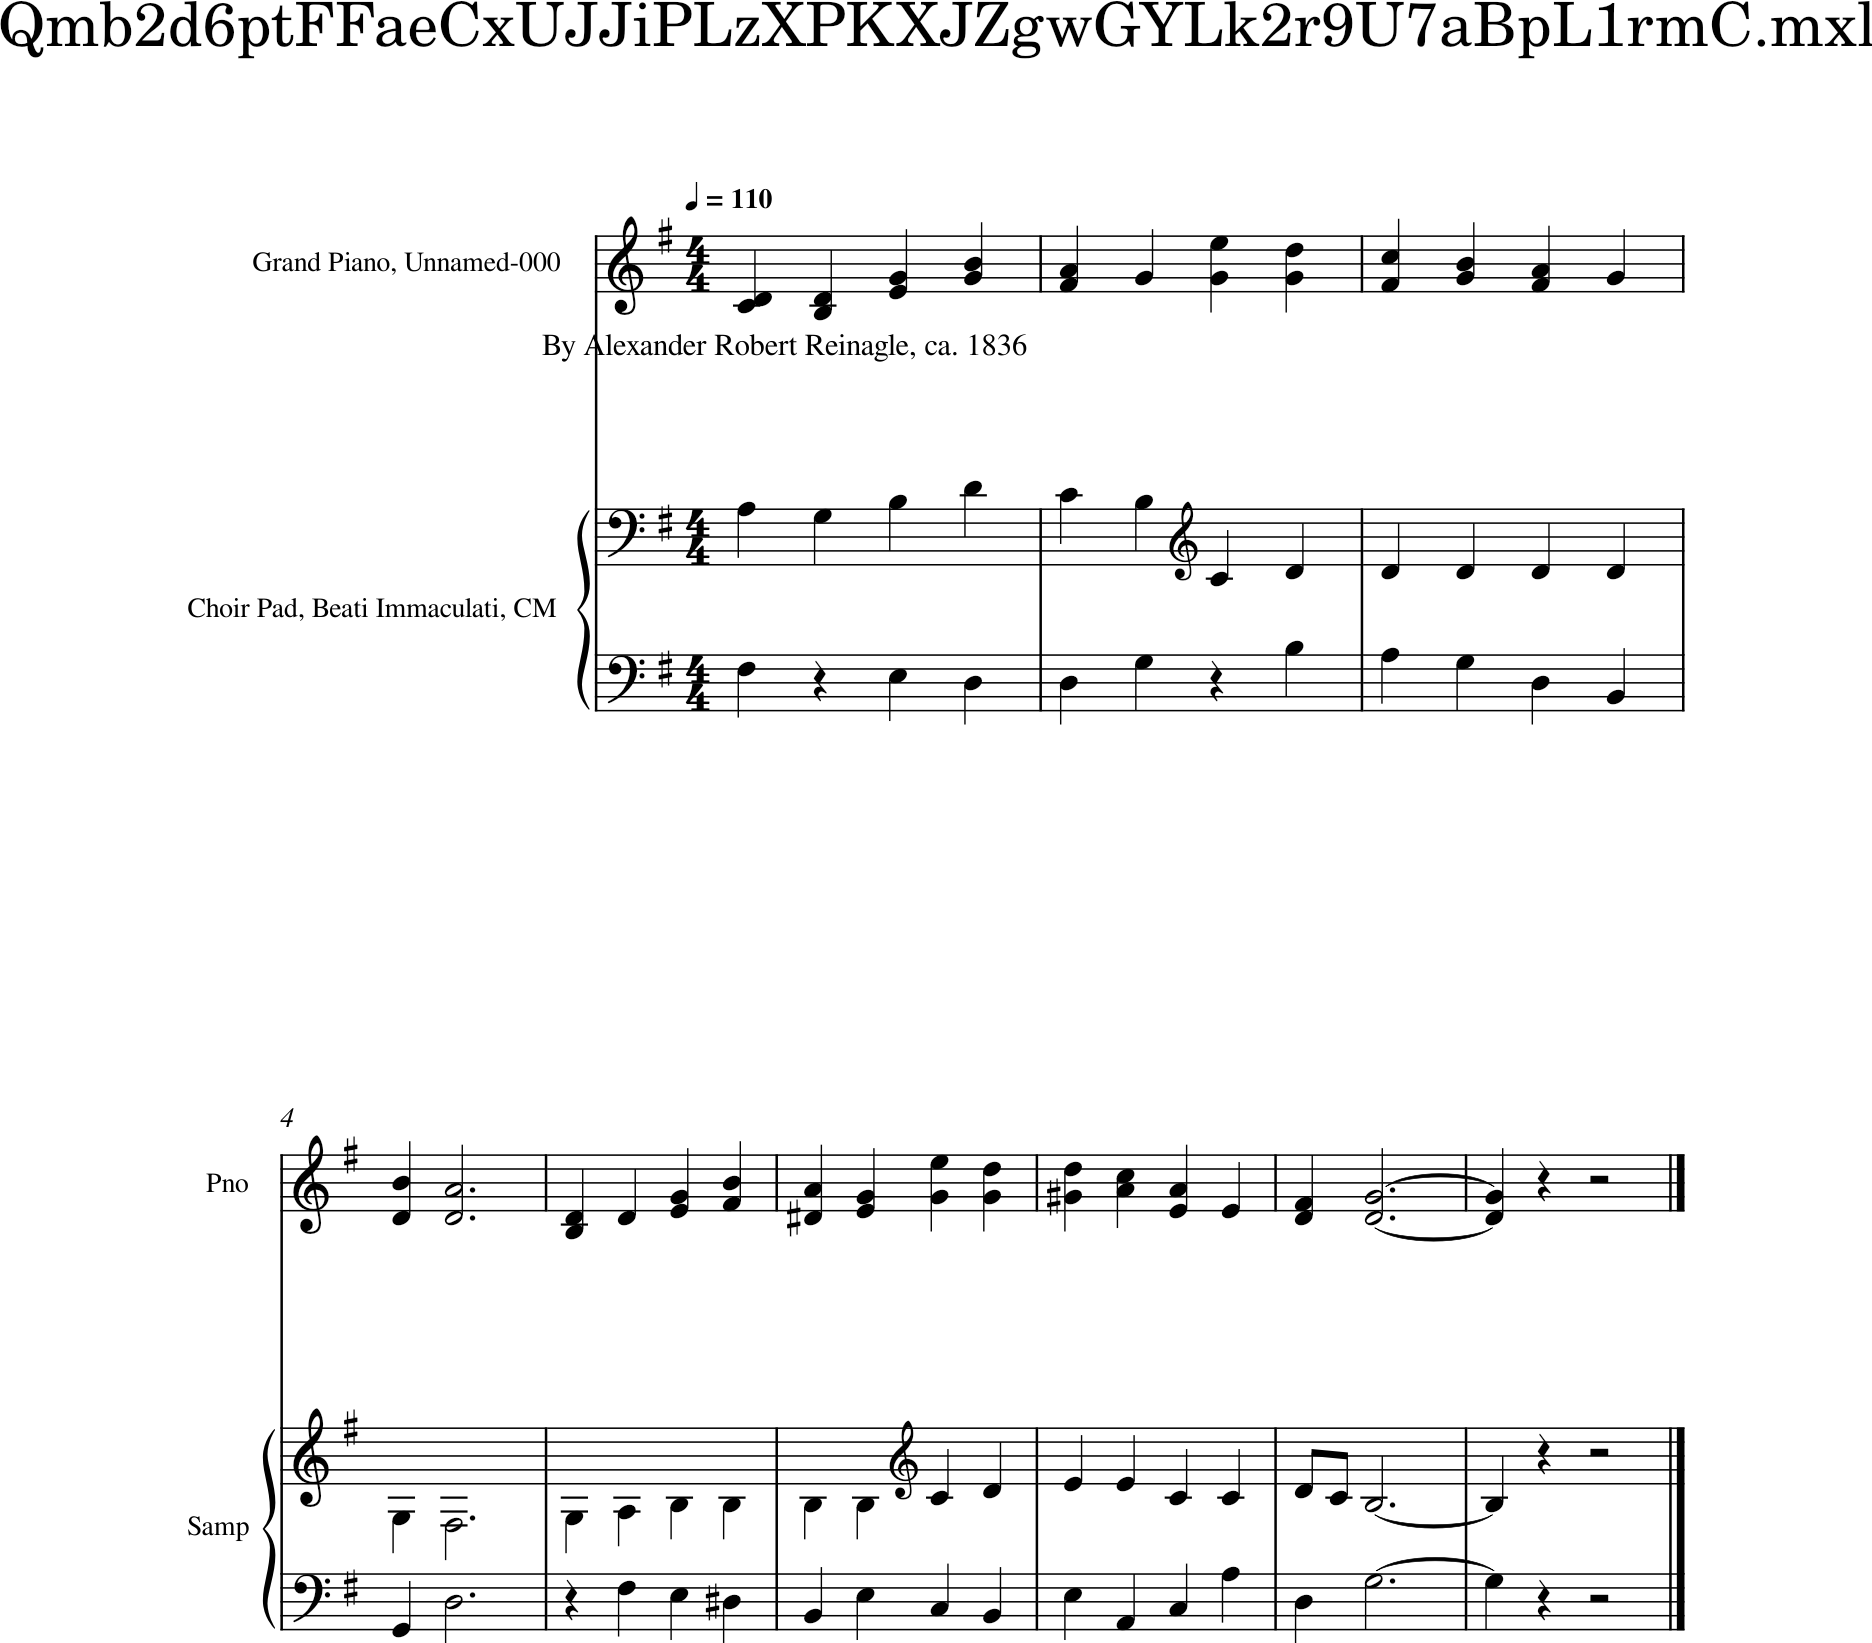


--- RECONSTRUCTED ---


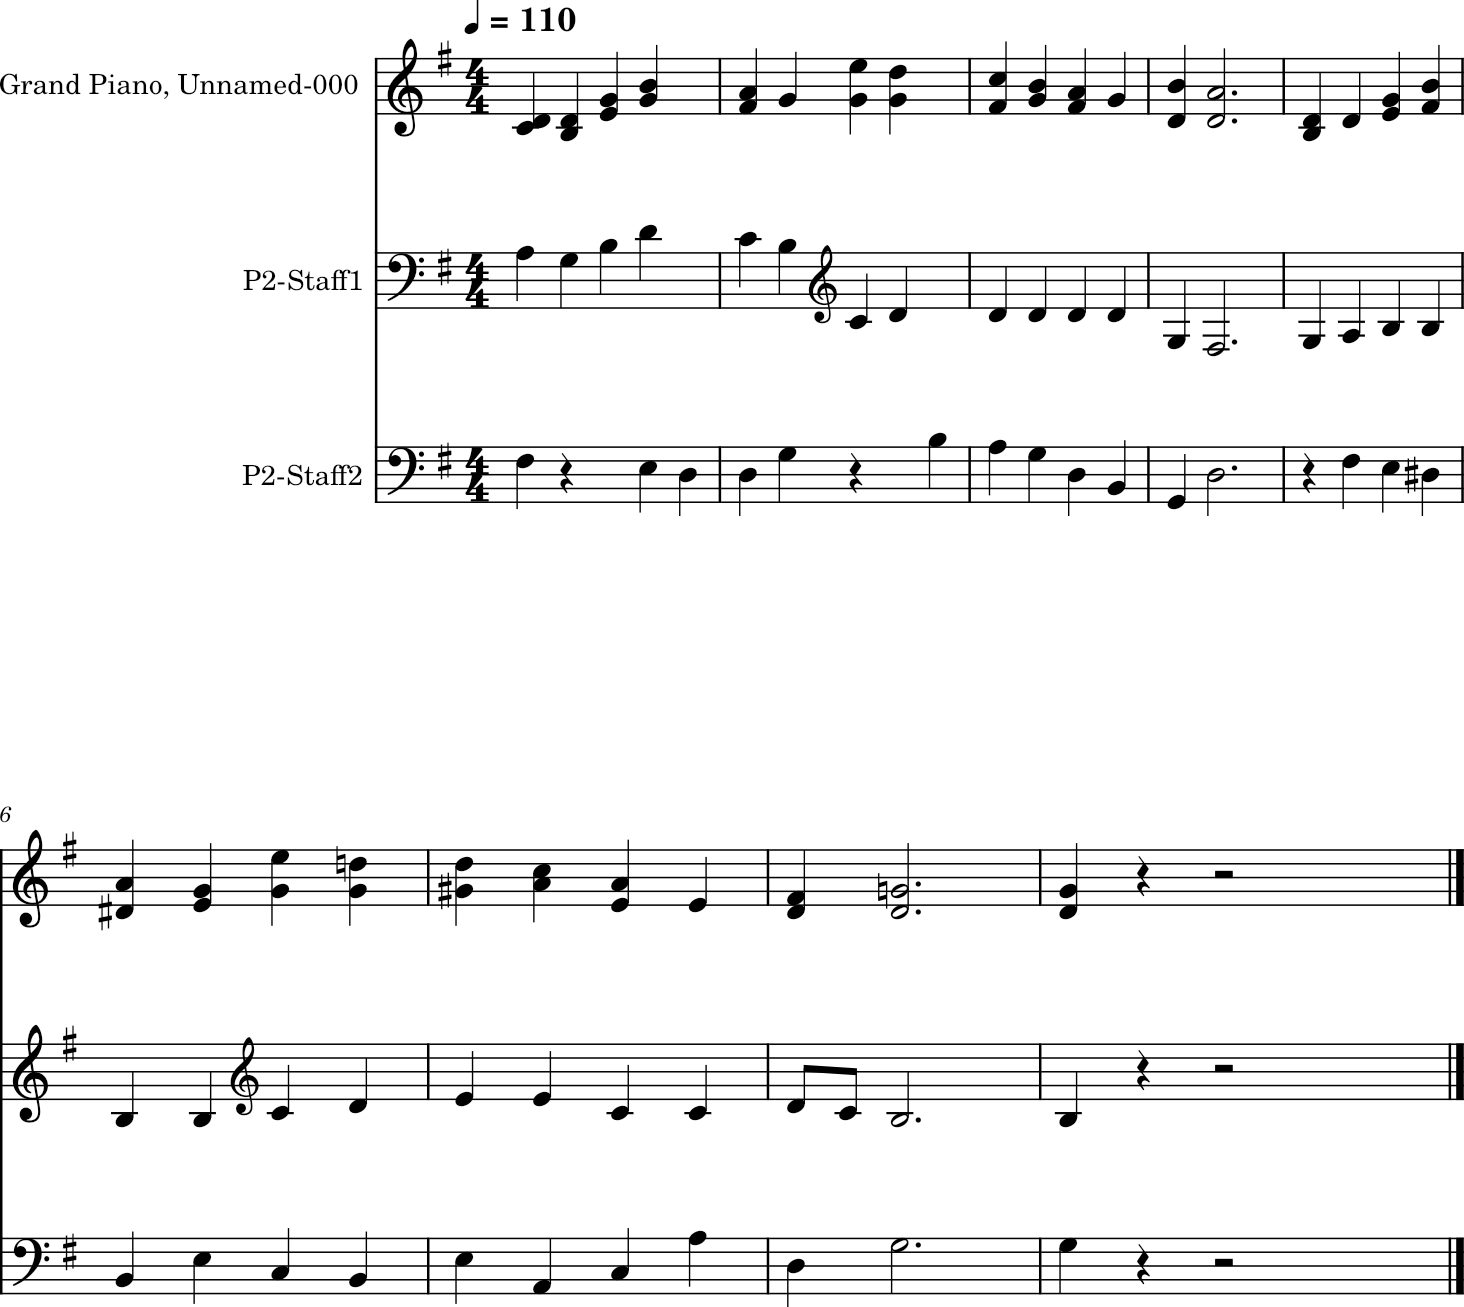

In [31]:
from pathlib import Path

folder = Path("examples")
files = sorted(folder.glob("*.mxl")) + sorted(folder.glob("*.xml")) + sorted(folder.glob("*.musicxml"))

for music_xml_path in files:
    print()
    print("=" * 80)
    print(f"  {music_xml_path.name}")
    print("=" * 80)

    original = music21.converter.parse(str(music_xml_path))
    tokens = tokenize(original)
    reconstructed = detokenize(tokens)

    print("\n--- ORIGINAL ---")
    original.show()

    print("\n--- RECONSTRUCTED ---")
    reconstructed.show()

Here i wanted to test is with music21 corpus, though I think that the examples I cherry picked earlier are more complex and harder to deal with. 

PASS  Bach BWV 66.6 (SATB Chorale)  (718 tokens)

--- ORIGINAL ---


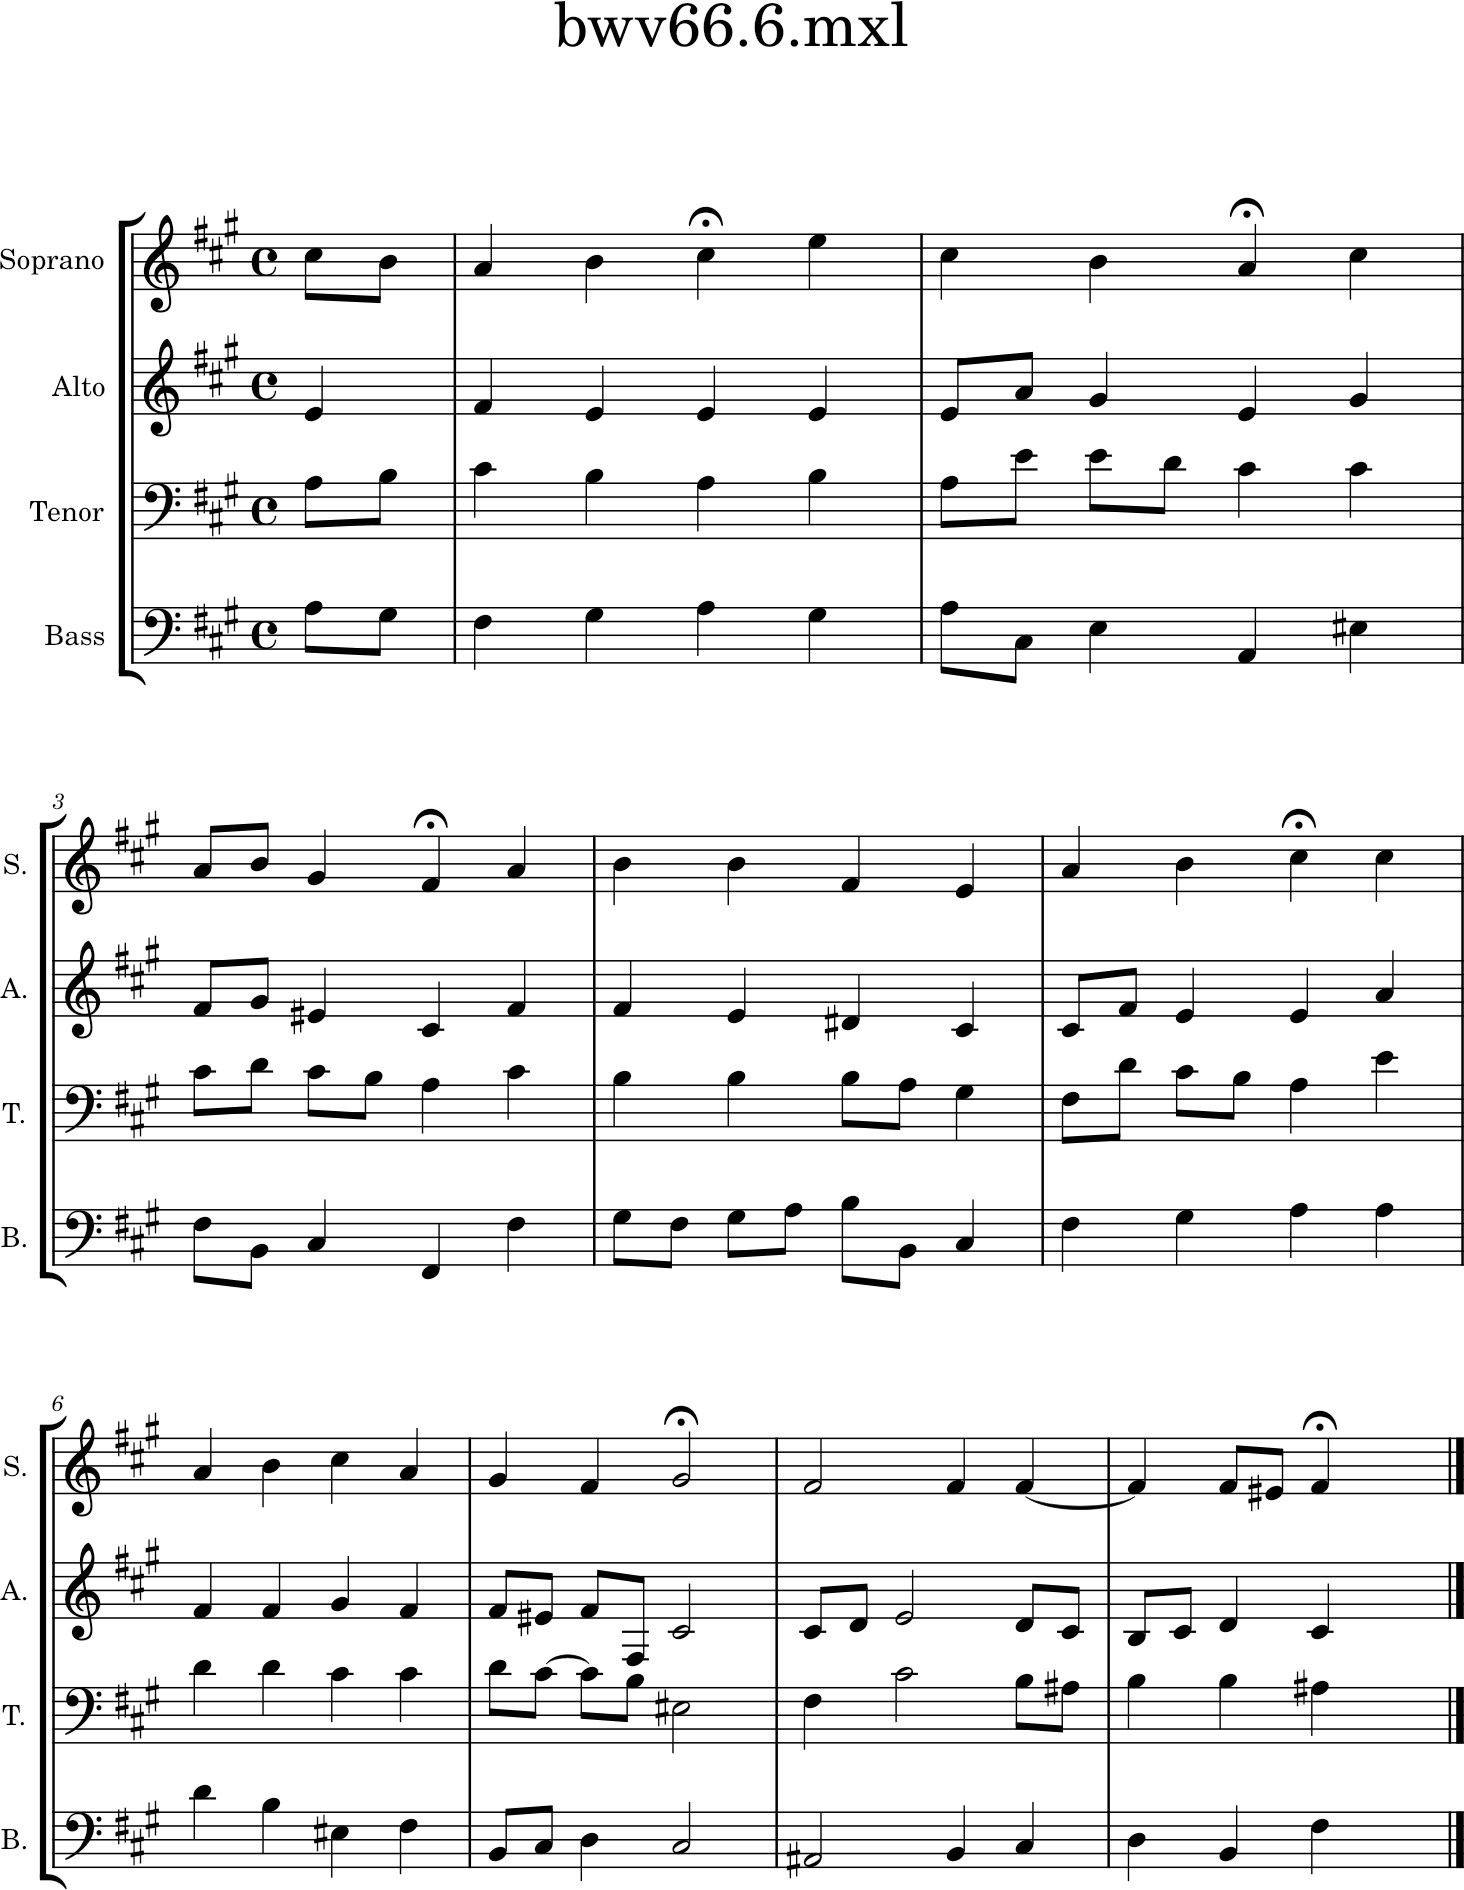


--- RECONSTRUCTED ---


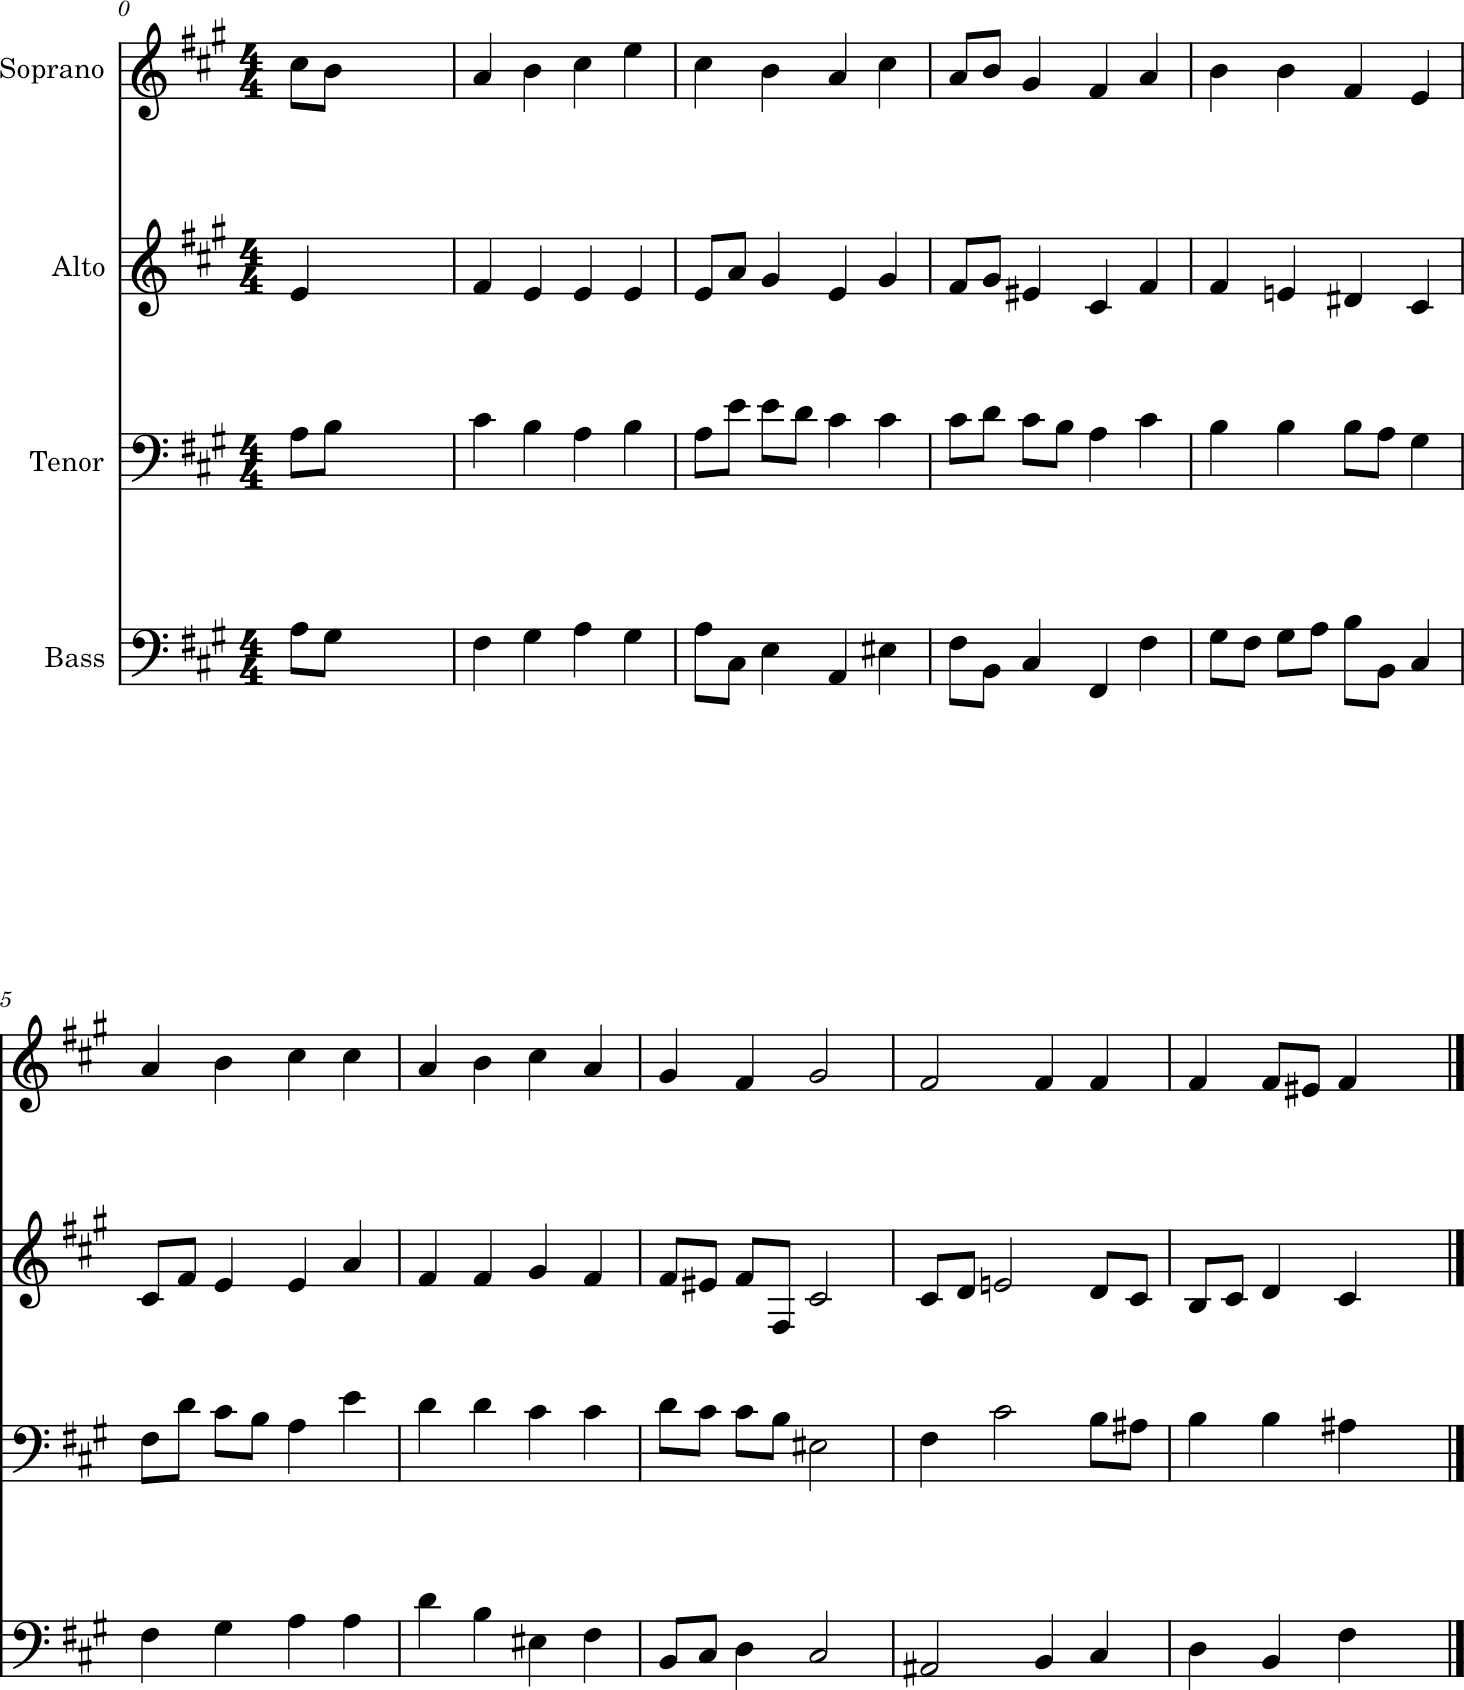

PASS  Bach BWV 65.2 (SATB Chorale)  (678 tokens)

--- ORIGINAL ---


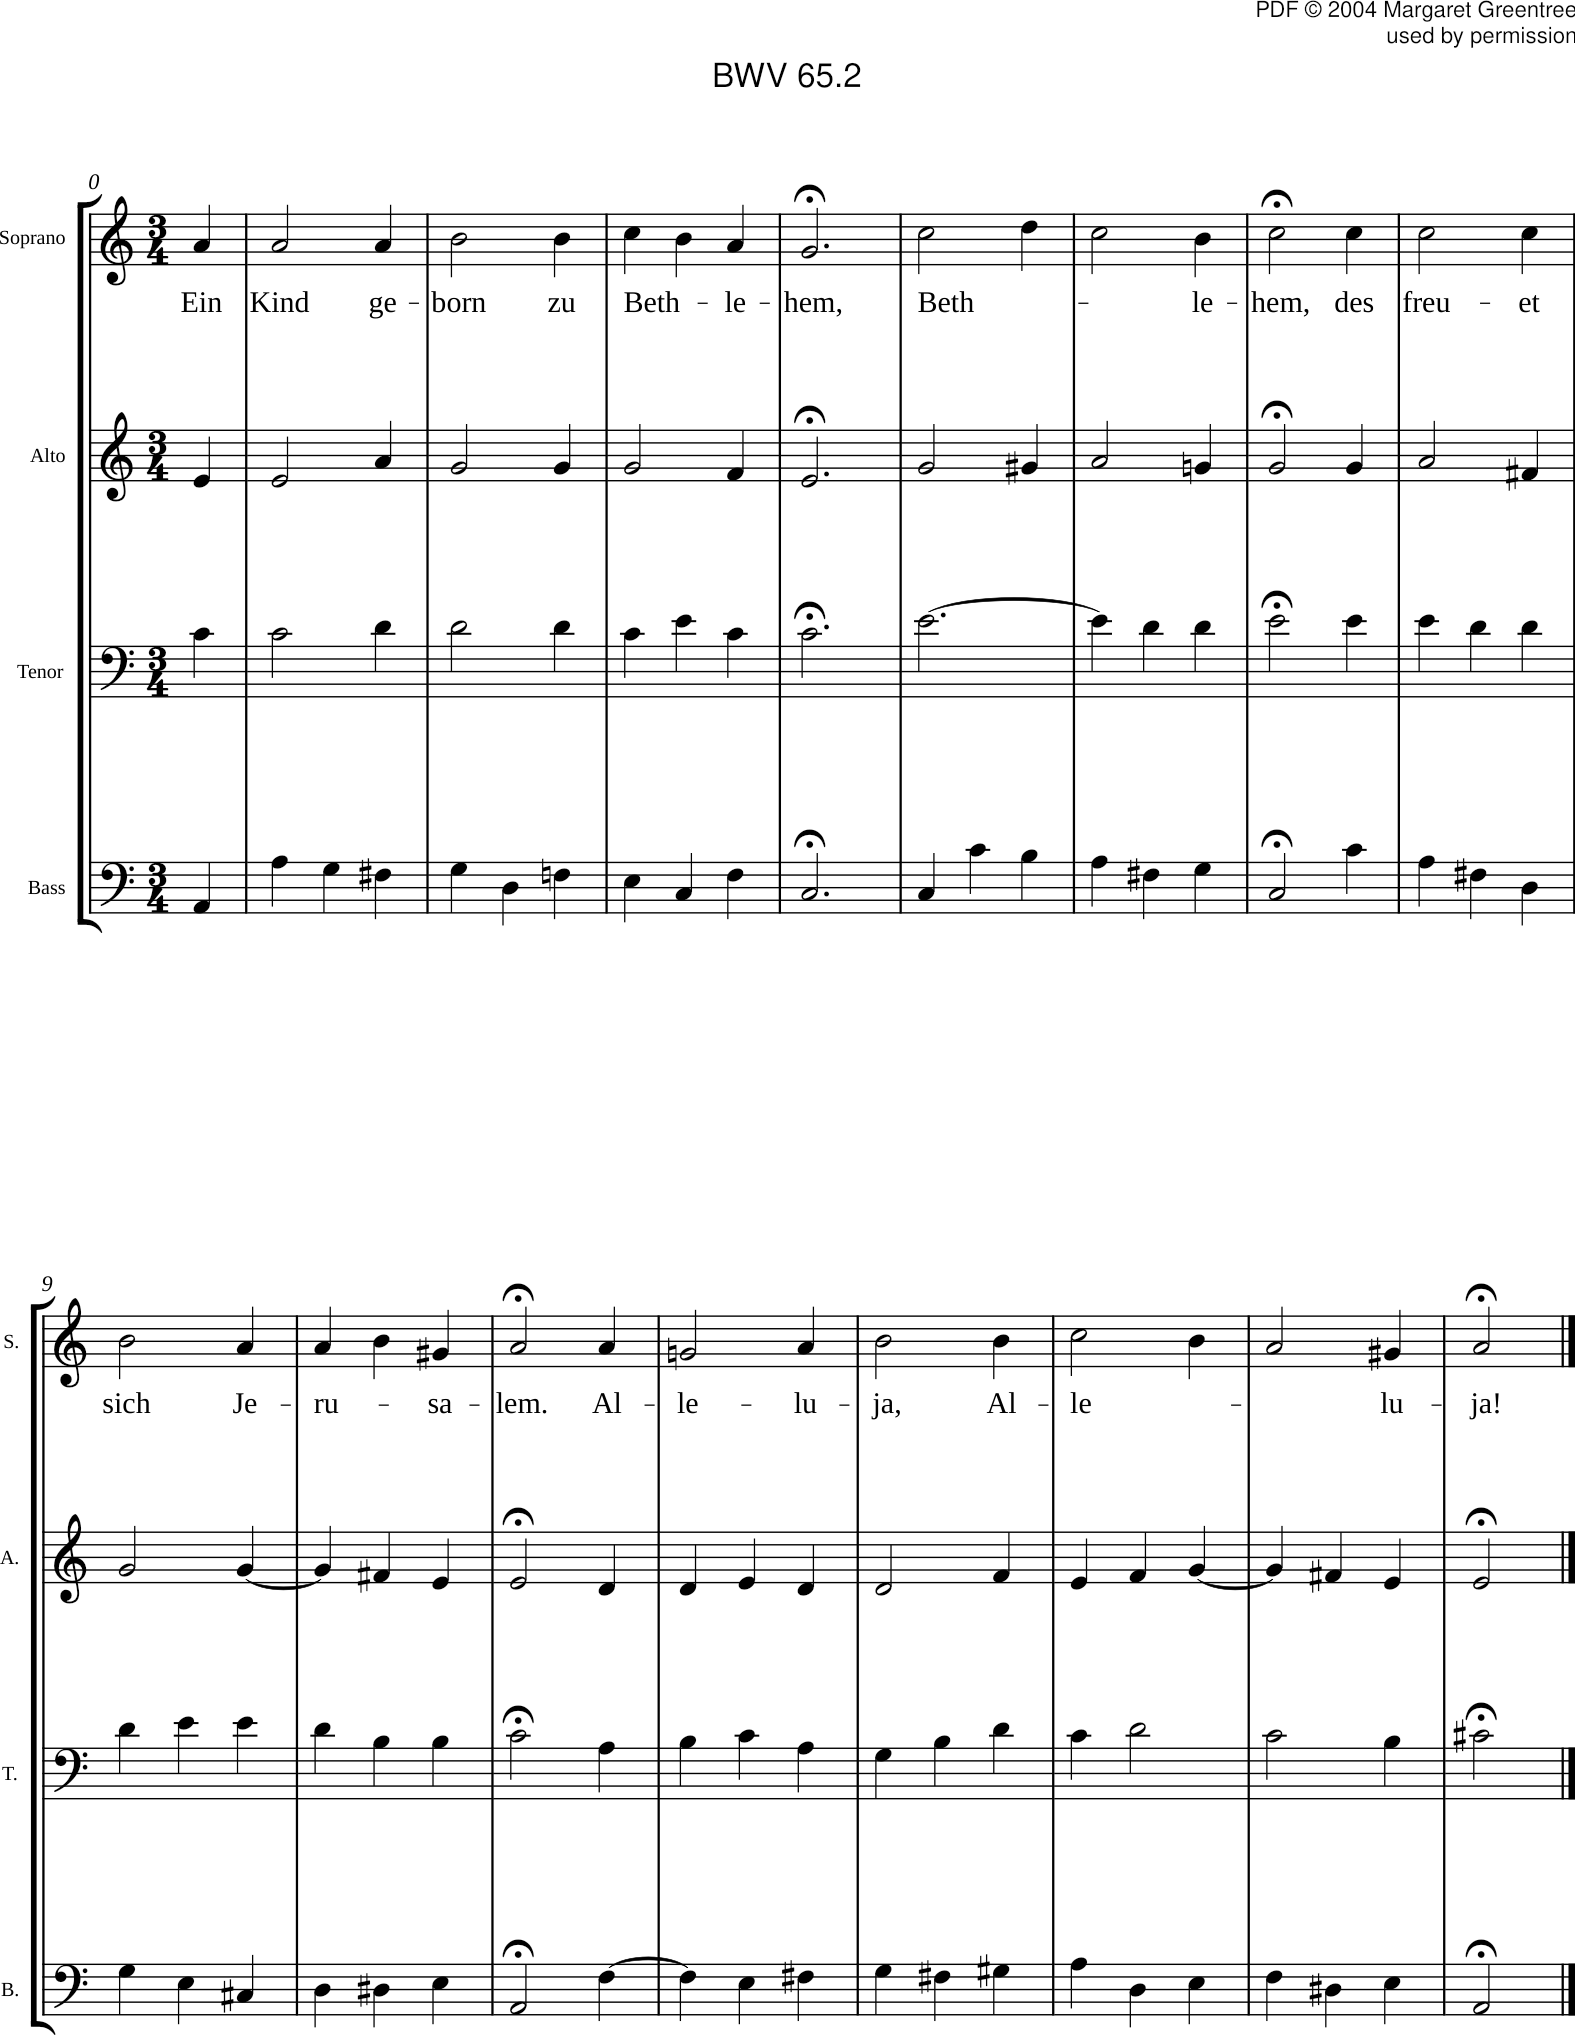


--- RECONSTRUCTED ---


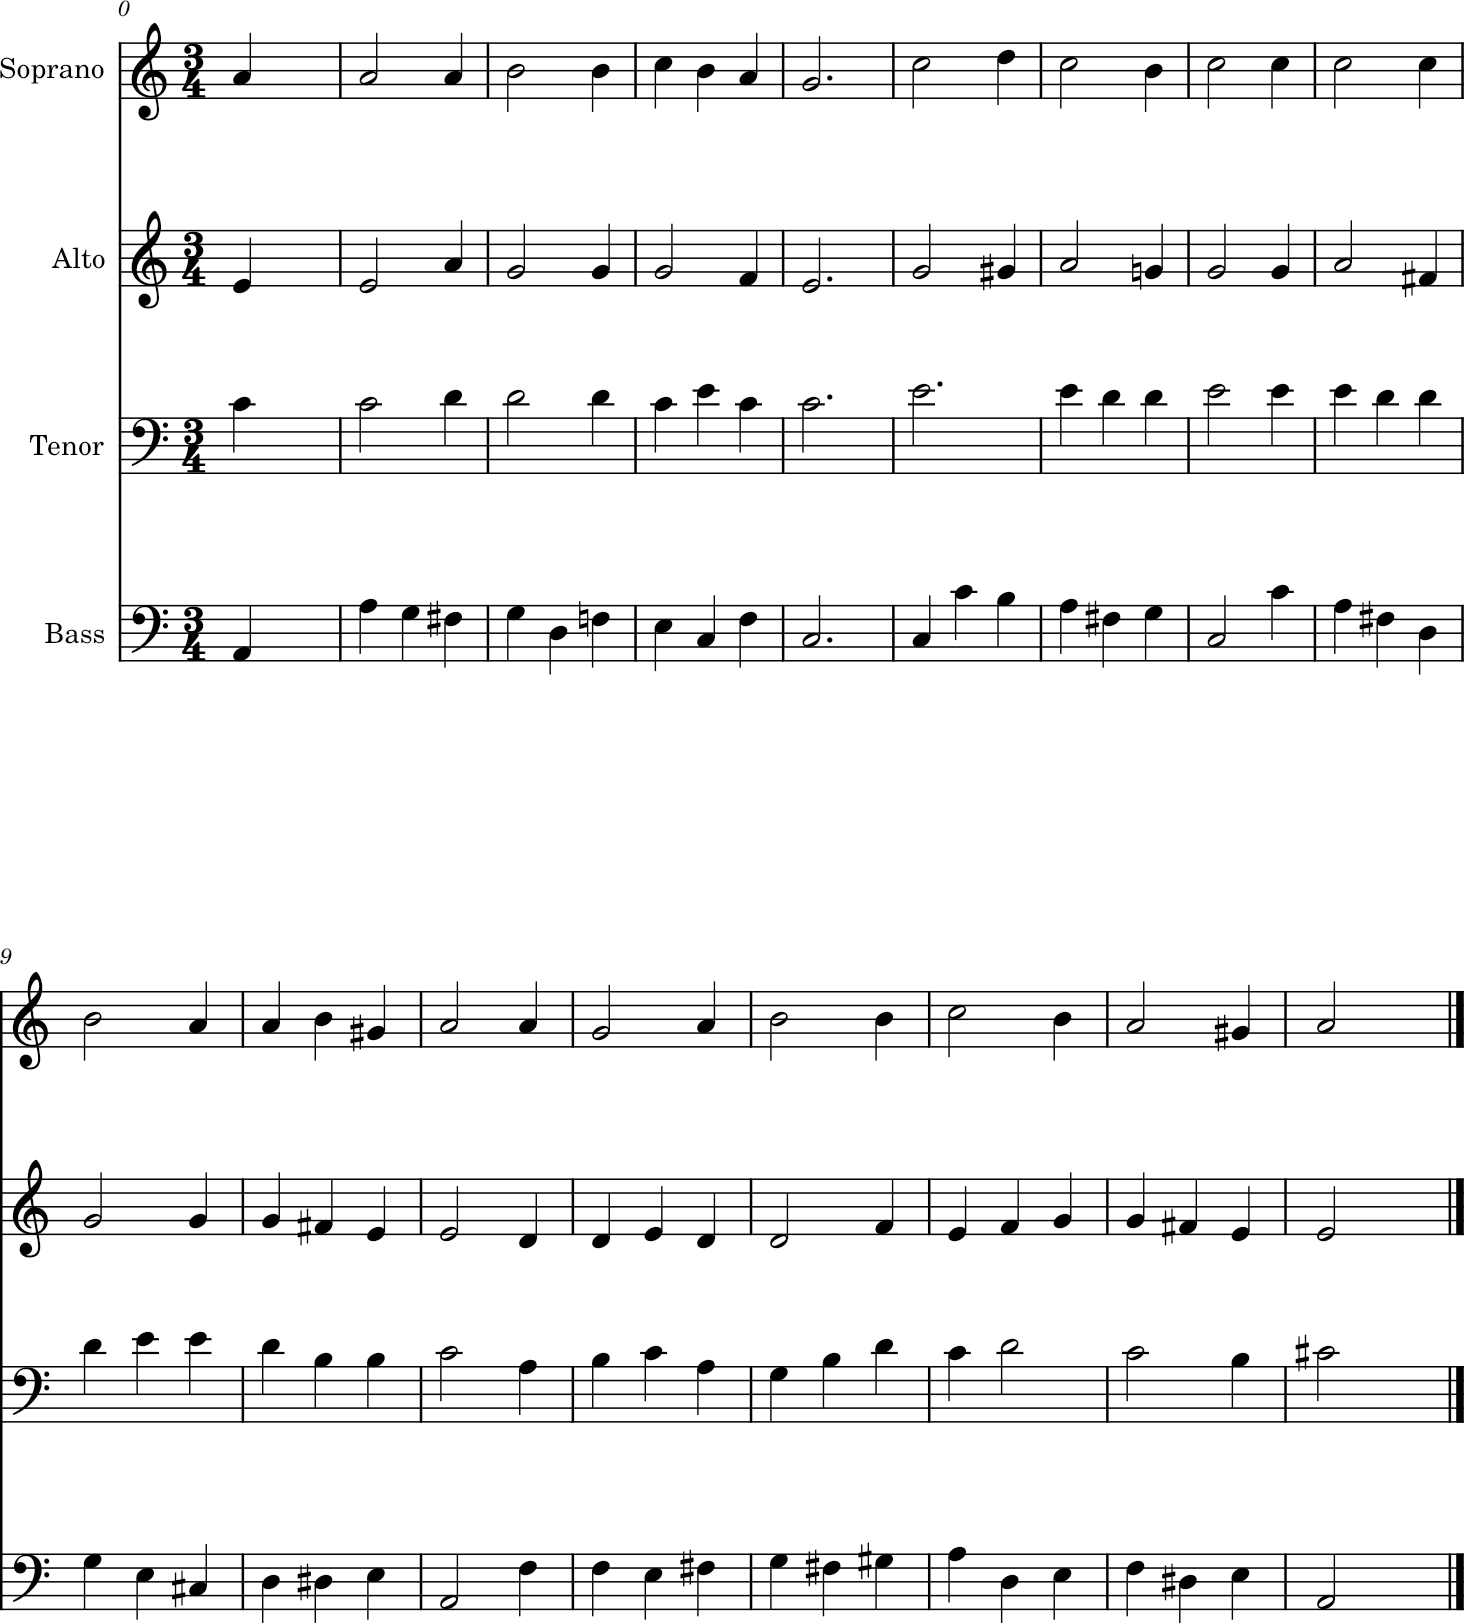


Real-world test summary: 2/2 passed


In [32]:
# ─── Real-world testing with music21 corpus ───────────────────────────────────

import os
import tempfile
from music21 import corpus, converter

# Curated test pieces from the music21 built-in corpus
REAL_WORLD_TESTS = [
    ("Bach BWV 66.6 (SATB Chorale)", "bach/bwv66.6"),
    ("Bach BWV 65.2 (SATB Chorale)", "bach/bwv65.2.xml"),
]

real_world_results = []

for label, corpus_path in REAL_WORLD_TESTS:
    try:
        score = corpus.parse(corpus_path)

        # Tokenize directly from the score object
        toks1 = tokenize(score)

        # Round-trip: detokenize → re-tokenize
        reconstructed = detokenize(toks1)
        toks2 = tokenize(reconstructed)

        match = toks1 == toks2
        real_world_results.append((label, len(toks1), match))

        status = "PASS" if match else "FAIL"
        print(f"{status}  {label}  ({len(toks1)} tokens)")

        if not match:
            for i, (a, b) in enumerate(zip(toks1, toks2)):
                if a != b:
                    print(f"       First diff at [{i}]: {a!r} vs {b!r}")
                    break

        print("\n--- ORIGINAL ---")
        score.show()
        print("\n--- RECONSTRUCTED ---")
        reconstructed.show()

    except Exception as e:
        print(f"SKIP  {label}: {e}")
        import traceback
        traceback.print_exc()
        real_world_results.append((label, 0, None))

tested = [r for r in real_world_results if r[2] is not None]
passed = sum(1 for r in tested if r[2])
print(f"\nReal-world test summary: {passed}/{len(tested)} passed")